In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

SEED = 123
TEST_SIZE = 0.3
CV = 5
SCORING = 'neg_log_loss'
N_ITER = 2500

In [2]:
def read_csv(path):
    dtypes = pd.read_csv(path, nrows=1).iloc[0].to_dict()
    return pd.read_csv(path, dtype=dtypes, skiprows=[1]).set_index("index")


def load_data(type_=None):
    if type_ is None:
        return read_csv(r"data/X.csv"), \
            read_csv(r"data/y.csv")

def train_test_split_data(type_=None, seed=None):
    X, y = load_data(type_=type_)
    
    if y.shape[0] > X.shape[0]:
        y = y.reindex(X.index)

    vars = pd.read_excel(r"data/vars.xlsx", engine='openpyxl')
    vars = vars[vars['discard'] == 0]['variable'].values.tolist()
    X = X.loc[:, [var for var in vars if var in X.columns]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=seed, stratify=y, shuffle=True)
    return X_train, X_test, y_train, y_test

models_path = r"data/models/{}/modseed={}.pkl"
mods = ["xgboo", 'logreg', "randfor", 'svm', "kneigh"]
seeds = seeds = [0, 8, 10, 23, 37, 42, 69, 99, 123, 747]
models = {}
parts = {seed: train_test_split_data(seed=seed) for seed in seeds}
for mod in mods:
    models[mod] = {}
    for seed in seeds:
        path = models_path.format(mod, seed)
        model = pd.read_pickle(path)
        models[mod][seed] = model
        

In [3]:
save = False
if save:
    import pickle
    a = {seed: models['xgboo'][seed]['model'] for seed in seeds}
    with open('models_xgboo.pickle', 'wb') as f:
        pickle.dump(a, f)

# Performance - test

In [4]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, auc, matthews_corrcoef
import seaborn as sns

res = dict(zip(mods, [None] * len(mods)))

for j, mod in enumerate(mods):
    mm = np.empty((len(seeds), 4))
    for i, seed in enumerate(seeds):
        p = (models[mod][seed]['probas'] > 0.5).astype(int)
        m1 = roc_auc_score(parts[seed][-1], models[mod][seed]['probas'])
        m2 = precision_recall_curve(parts[seed][-1], models[mod][seed]['probas'])
        m2 = auc(m2[1], m2[0])
        m3 = average_precision_score(parts[seed][-1], models[mod][seed]['probas'])
        m4 = matthews_corrcoef(parts[seed][-1], p)
        mm[i, :] = [m1, m2, m3, m4]
    res[mod] = pd.DataFrame(mm, columns=['roc', 'prc', 'avp', 'mcc'])
    
m1 = res['logreg'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m1['model'] = 'logreg'
# m2 = res['naivebayes'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
# m2['model'] = 'naivebayes'
m3 = res['svm'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m3['model'] = 'svm'
m4 = res['randfor'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m4['model'] = 'randfor'
m5 = res['xgboo'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m5['model'] = 'xgboo'
m6 = res['kneigh'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m6['model'] = 'kneigh'
mm = pd.concat([m5, m1, m4, m3, m6]) # m2

In [5]:
mm = mm.replace({'metric': {"roc": "AUC-ROC Score", "avp": "Average Precision Score", "prc": "Precision-Recall AUC Score",
                           "mcc": "Mathew's Correlation Coefficient"}, 
            'model': {"logreg": "Logistic Clf.", "randfor": "Random Forest", 
                      "xgboo": "XGBoost", 'naivebayes': 'N. Bayes', "svm": 'SVM', "kneigh": "K Neighbors"}}).rename(
columns={'metric': 'Métrica', "value": "Valor", "model": 'Model'})

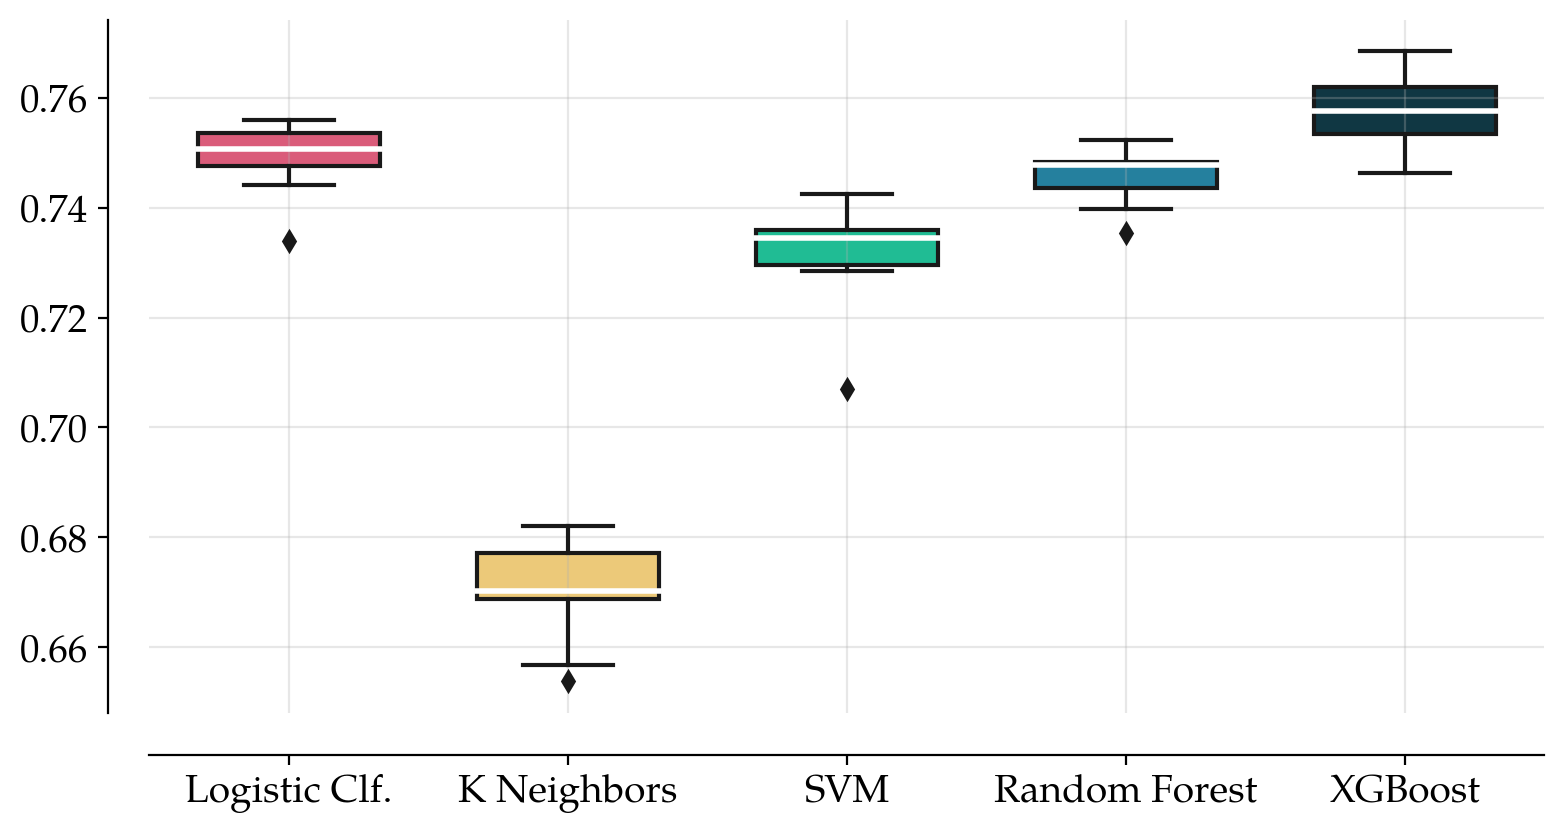

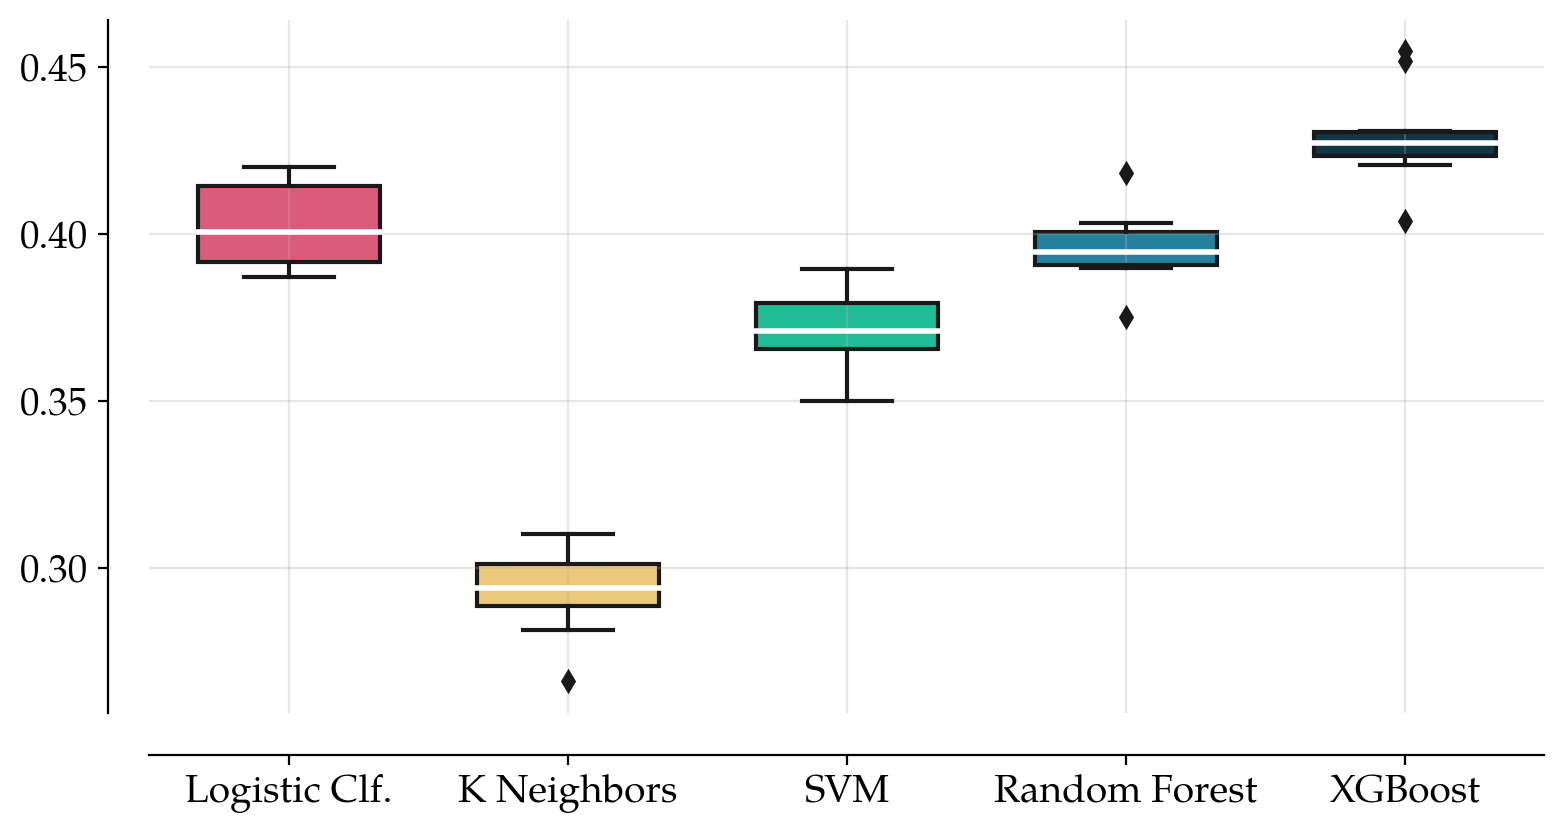

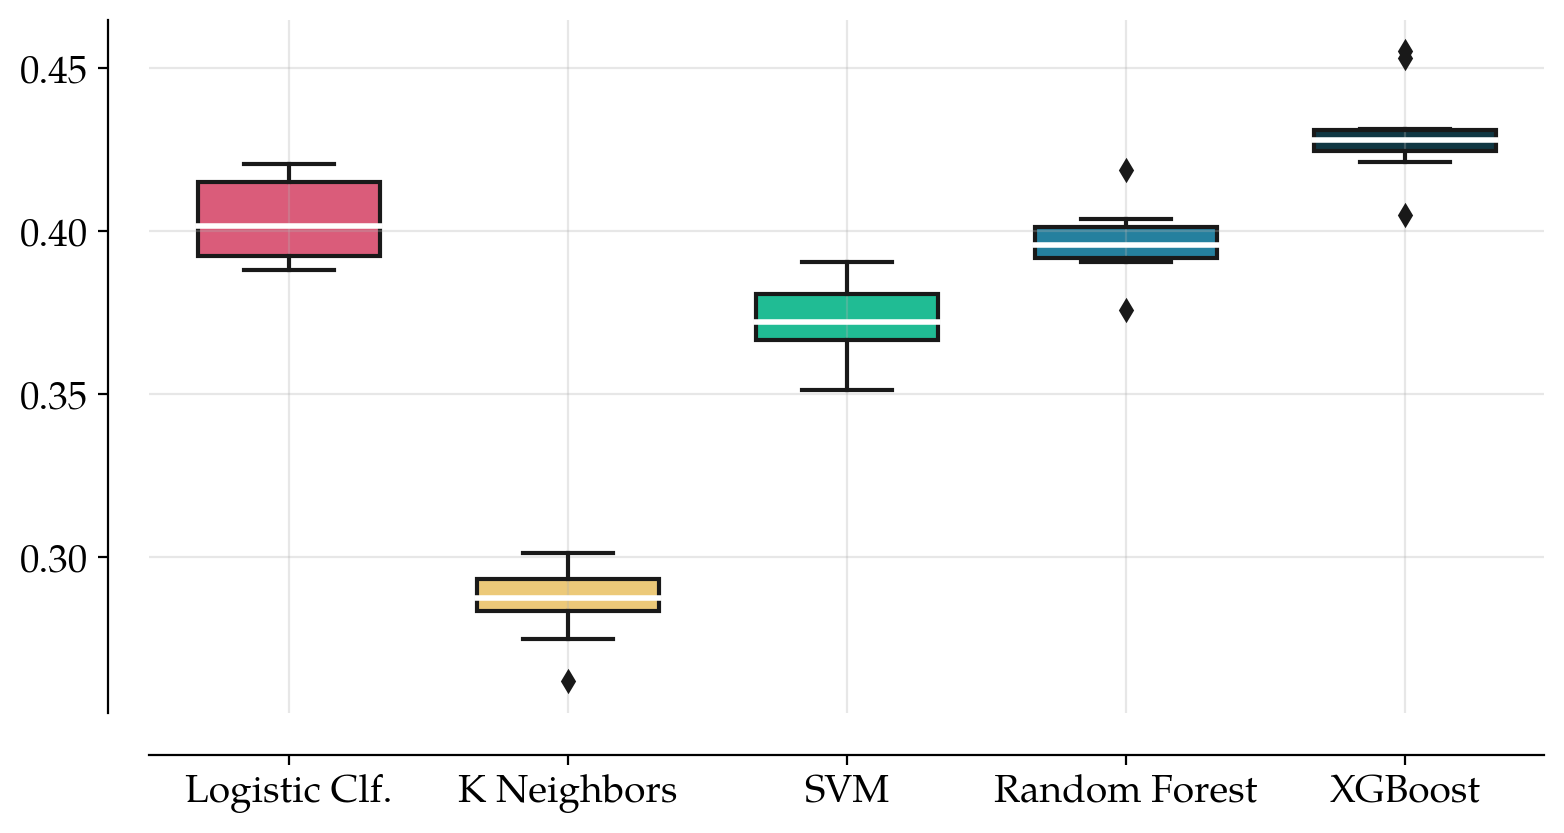

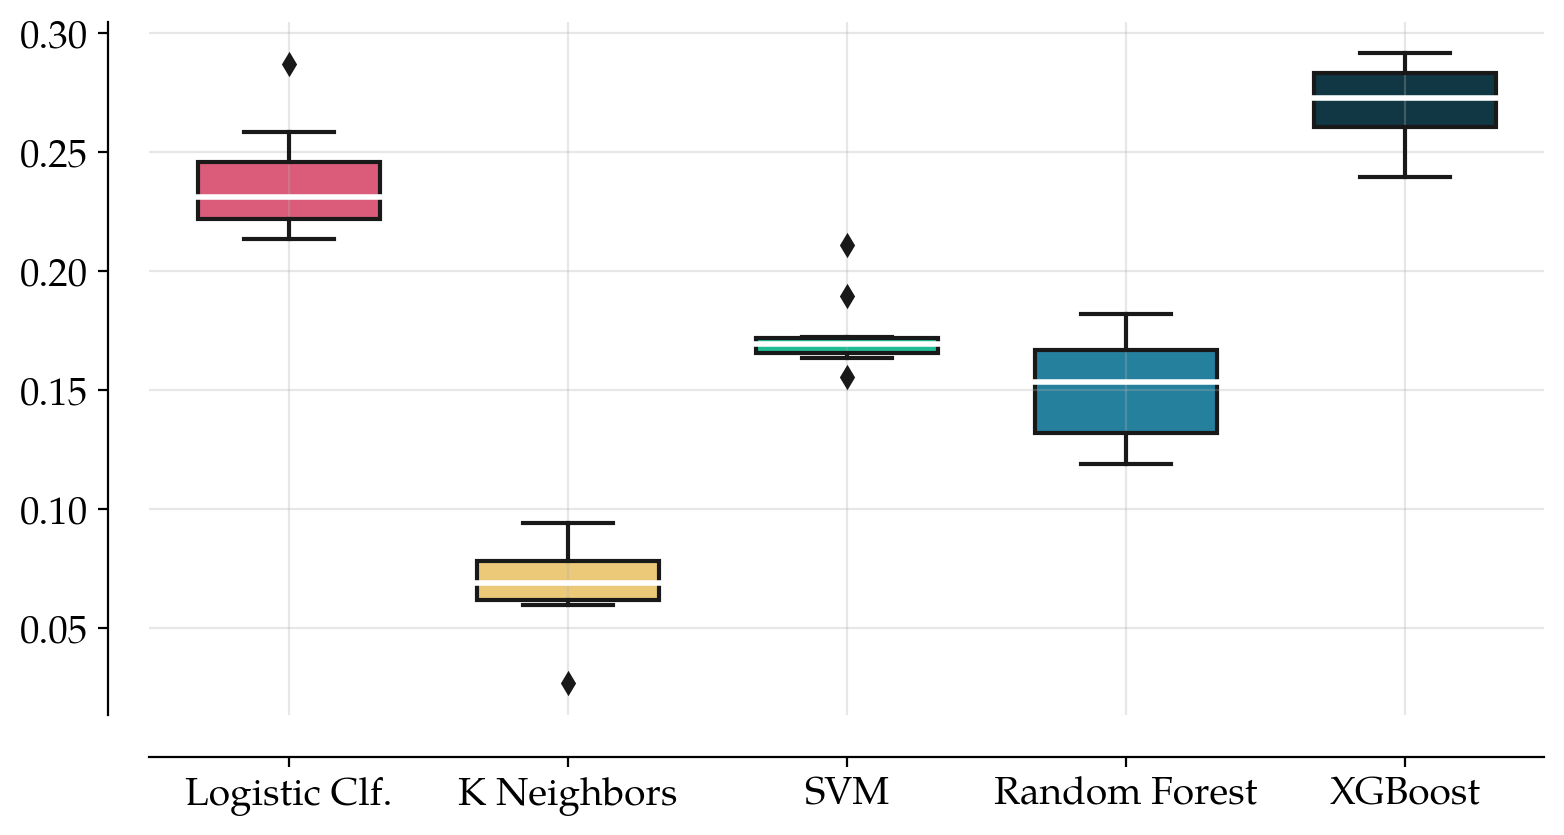

In [6]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from matplotlib import font_manager

font_dir = r'C:\Users\q31984\AppData\Local\Microsoft\Windows\Fonts\palatino.ttf'
font_manager.fontManager.addfont(font_dir)
plt.rcParams['font.family'] = 'Palatino'
plt.rcParams['font.size'] = 14

pal = ['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c']

dfsplot = list()


for metric in mm['Métrica'].unique():
    
    fig, ax = plt.subplots(1,1, figsize=(9, 4.5))
    df = mm[mm['Métrica']==metric].sort_values(by='Model')
    dfsplot.append(df.assign(metric=metric))
    #sns.swarmplot(x='Model', y='Valor', data=df, palette=pal, size=10)
    sns.boxplot(x='Model', y='Valor', data=df, palette=pal, 
                linewidth=1.5, width=.65,
                medianprops=dict(color="white", alpha=1, linewidth=2), order=["Logistic Clf.", "K Neighbors", "SVM", "Random Forest", "XGBoost"])
    # sns.barplot(x='Model', y='Valor', data=df, ci=None, alpha=0.3)
    ax.grid(alpha=0.3)
    ax.set(xlabel=None, ylabel=None)
    # ax.set_title("Model performance for {}".format(metric))
    sns.despine(offset=15);
    plt.show()
    fig.savefig(r"img/{}.png".format(metric), dpi=300)

In [7]:
g = pd.concat(dfsplot)

In [8]:
g = g[g["metric"].isin(['AUC-ROC Score', 'Precision-Recall AUC Score'])]

In [9]:
g = g.replace({"Model": {"K Neighbors": "KNN", "Logistic Clf.": "Log. Reg."}}).rename(columns={"Model": "Classifier"})

In [10]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

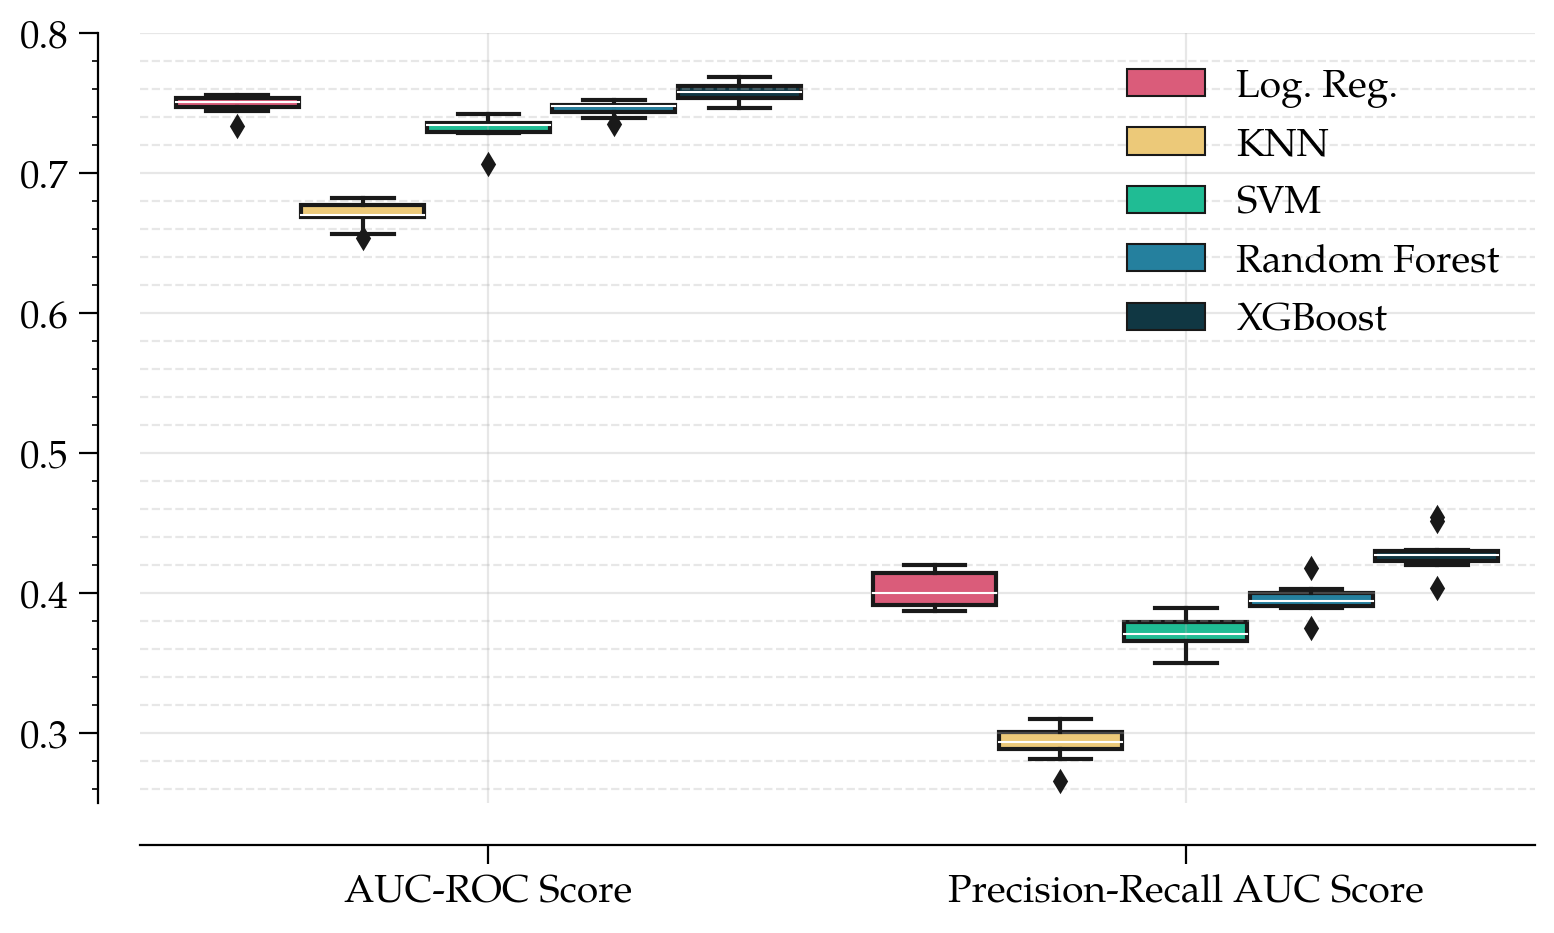

In [11]:
fig, ax = plt.subplots(1,1, figsize=(9, 5))
sns.boxplot(x='metric', y='Valor', data=g, palette=pal, hue="Classifier",
                linewidth=1.5, width=0.9,
                medianprops=dict(color="white", linewidth=0.75), hue_order=["Log. Reg.", "KNN", "SVM", "Random Forest", "XGBoost"])
    # sns.barplot(x='Model', y='Valor', data=df, ci=None, alpha=0.3)
ax.grid(alpha=0.3, )
ax.grid(alpha=.3, which='minor', linestyle='--')
ax.set(xlabel=None, ylabel=None)
# ax.set_title("Model performance for {}".format(metric))
sns.despine(offset=15);
plt.ylim(0.25, 0.8)
 # ax.set_yticklabels(np.arange(0.25, 0.8, 0.025), minor=False)
ax.yaxis.set_minor_locator(AutoMinorLocator())

# ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.legend(loc='best',
          fancybox=False, shadow=False, ncol=1, frameon=False)
plt.show()
fig.savefig(r"img/{}.png".format("bothmetrics"), dpi=300)

In [12]:
print(mm.groupby(['Model', 'Métrica']).mean().reset_index().pivot(
    values='Valor', columns='Métrica', index='Model').round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
Métrica &  AUC-ROC Score &  Average Precision Score &  Mathew's Correlation Coefficient &  Precision-Recall AUC Score \\
Model         &                &                          &                                   &                             \\
\midrule
K Neighbors   &          0.670 &                    0.286 &                             0.069 &                       0.293 \\
Logistic Clf. &          0.749 &                    0.403 &                             0.237 &                       0.403 \\
Random Forest &          0.746 &                    0.397 &                             0.150 &                       0.396 \\
SVM           &          0.732 &                    0.372 &                             0.173 &                       0.371 \\
XGBoost       &          0.758 &                    0.430 &                             0.271 &                       0.429 \\
\bottomrule
\end{tabular}



C:\Users\q31984\AppData\Local\Temp\ipykernel_35264\1888333554.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mm.groupby(['Model', 'Métrica']).mean().reset_index().pivot(


In [13]:
print(mm.groupby(['Model', 'Métrica']).std().reset_index().pivot(
    values='Valor', columns='Métrica', index='Model').round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
Métrica &  AUC-ROC Score &  Average Precision Score &  Mathew's Correlation Coefficient &  Precision-Recall AUC Score \\
Model         &                &                          &                                   &                             \\
\midrule
K Neighbors   &          0.009 &                    0.011 &                             0.019 &                       0.013 \\
Logistic Clf. &          0.007 &                    0.012 &                             0.023 &                       0.012 \\
Random Forest &          0.005 &                    0.011 &                             0.023 &                       0.011 \\
SVM           &          0.010 &                    0.012 &                             0.016 &                       0.012 \\
XGBoost       &          0.007 &                    0.015 &                             0.017 &                       0.015 \\
\bottomrule
\end{tabular}



C:\Users\q31984\AppData\Local\Temp\ipykernel_35264\2036604375.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mm.groupby(['Model', 'Métrica']).std().reset_index().pivot(


In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
ts = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
sem = list()
cuts = list()
for model in mods:
    ms = models[model]
    for i, seed in enumerate(seeds):
        x_train = parts[seed][0]
        y_train = parts[seed][2]
        x_test = parts[seed][1]
        y_test = parts[seed][-1]
        m = ms[seed]['model']
        p = ms[seed]['probas']
        cut = pd.cut(pd.Series(p), 
                     bins=np.arange(0, 11, 1) / 10, 
                     labels=np.arange(1, 11, 1))
        df = pd.concat([pd.DataFrame(p), 
                        cut, 
                        y_test.reset_index().drop(
                            "index", axis=1)], axis=1)
        df.columns = ['prob', 'bin', 'true']
        df['model'] = model
        df['seed'] = seed
        cuts.append(df)
        v = np.empty((len(ts), 4))
        for j, t in enumerate(ts):
            x = df.copy()
            x['pred'] = x['prob'] >= t
            tn, fp, fn, tp = confusion_matrix(x['true'], x['pred']).ravel()
            s = tn + fp + fn + tp
            v[j, :] = [tn, fp, fn, tp]
        v = pd.DataFrame(data=v, columns=['tn', 'fp', 'fn', 'tp'], index=ts)
        v = v.stack().reset_index()
        v.columns = ['threshold', 'type', 'count']
        v['seed'] = seed
        v['model'] = model
        sem.append(v)
    print(model)

xgboo
logreg
randfor
svm
kneigh


In [16]:
x = pd.concat(sem)

In [17]:
def precision(data):
    tp = data[data['type'] == 'tp']['count'].values
    fp = data[data['type'] == 'fp']['count'].values
    return np.median(tp / (tp + fp))

def recall(data):
    tp = data[data['type'] == 'tp']['count'].values
    fn = data[data['type'] == 'fn']['count'].values
    return np.median(tp / (tp + fn))

def accuracy(data):
    tp = data[data['type'] == 'tp']['count'].values
    fp = data[data['type'] == 'fp']['count'].values
    fn = data[data['type'] == 'fn']['count'].values
    tn = data[data['type'] == 'tn']['count'].values
    return np.median((tp + tn) / (tn + fp + fn + tp))

In [18]:
mods

['xgboo', 'logreg', 'randfor', 'svm', 'kneigh']

In [19]:
x = x.replace({'model': dict(zip(mods, ['XGBoost', 'Logistic Clf.', 'Random Forest', 'SVM', "K Neighbors"]))})

In [20]:
prec = x.groupby(['model', 'threshold']).apply(
    lambda x: precision(x)).reset_index().rename(
    columns={0: 'precision'}).pivot(
    values='precision', columns='model', index='threshold')

rec = x.groupby(['model', 'threshold']).apply(
    lambda x: recall(x)).reset_index().rename(
    columns={0: 'recall'}).pivot(
    values='recall', columns='model', index='threshold')

acc = x.groupby(['model', 'threshold']).apply(
    lambda x: accuracy(x)).reset_index().rename(
    columns={0: 'accuracy'}).pivot(
    values='accuracy', columns='model', index='threshold')

f1 = 2 * (prec * rec) / (prec + rec)

In [21]:
plotnames = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
plots = dict(zip(plotnames, [prec, rec, acc, f1]))

<AxesSubplot: xlabel='threshold'>

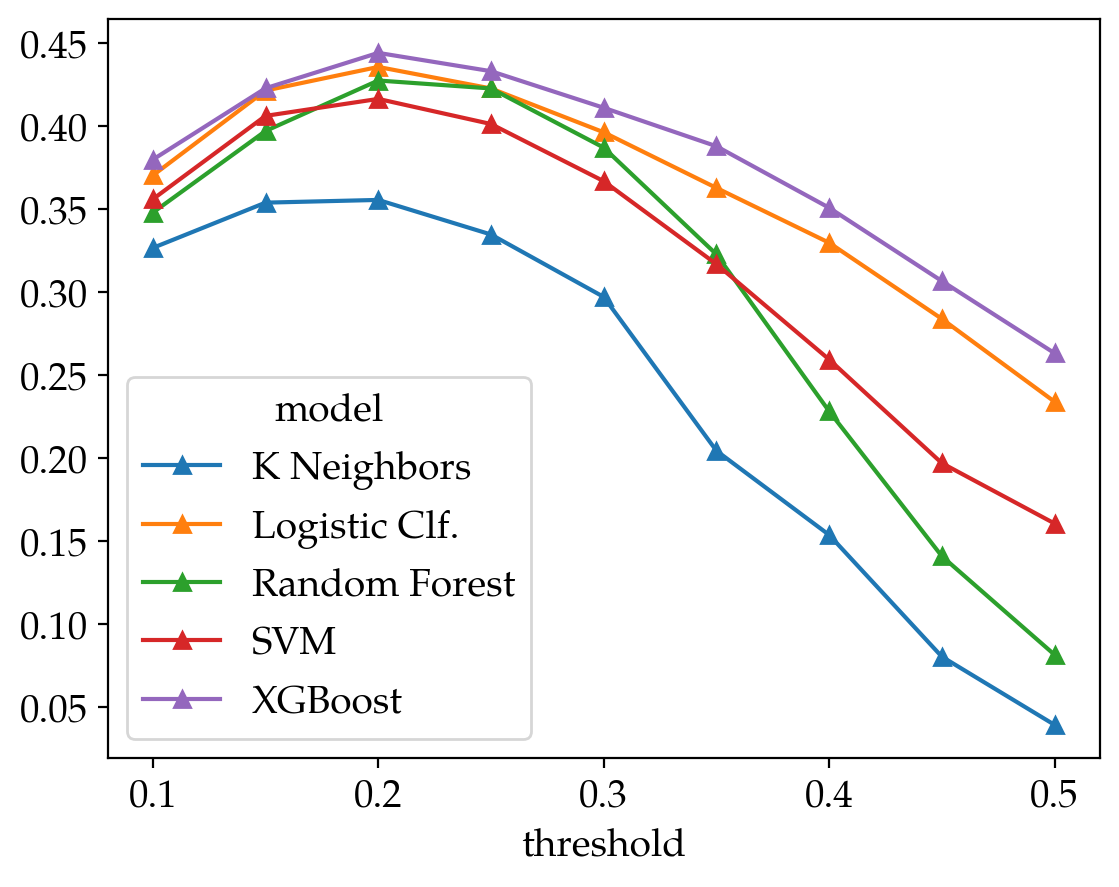

In [22]:
f1.plot(marker='^')

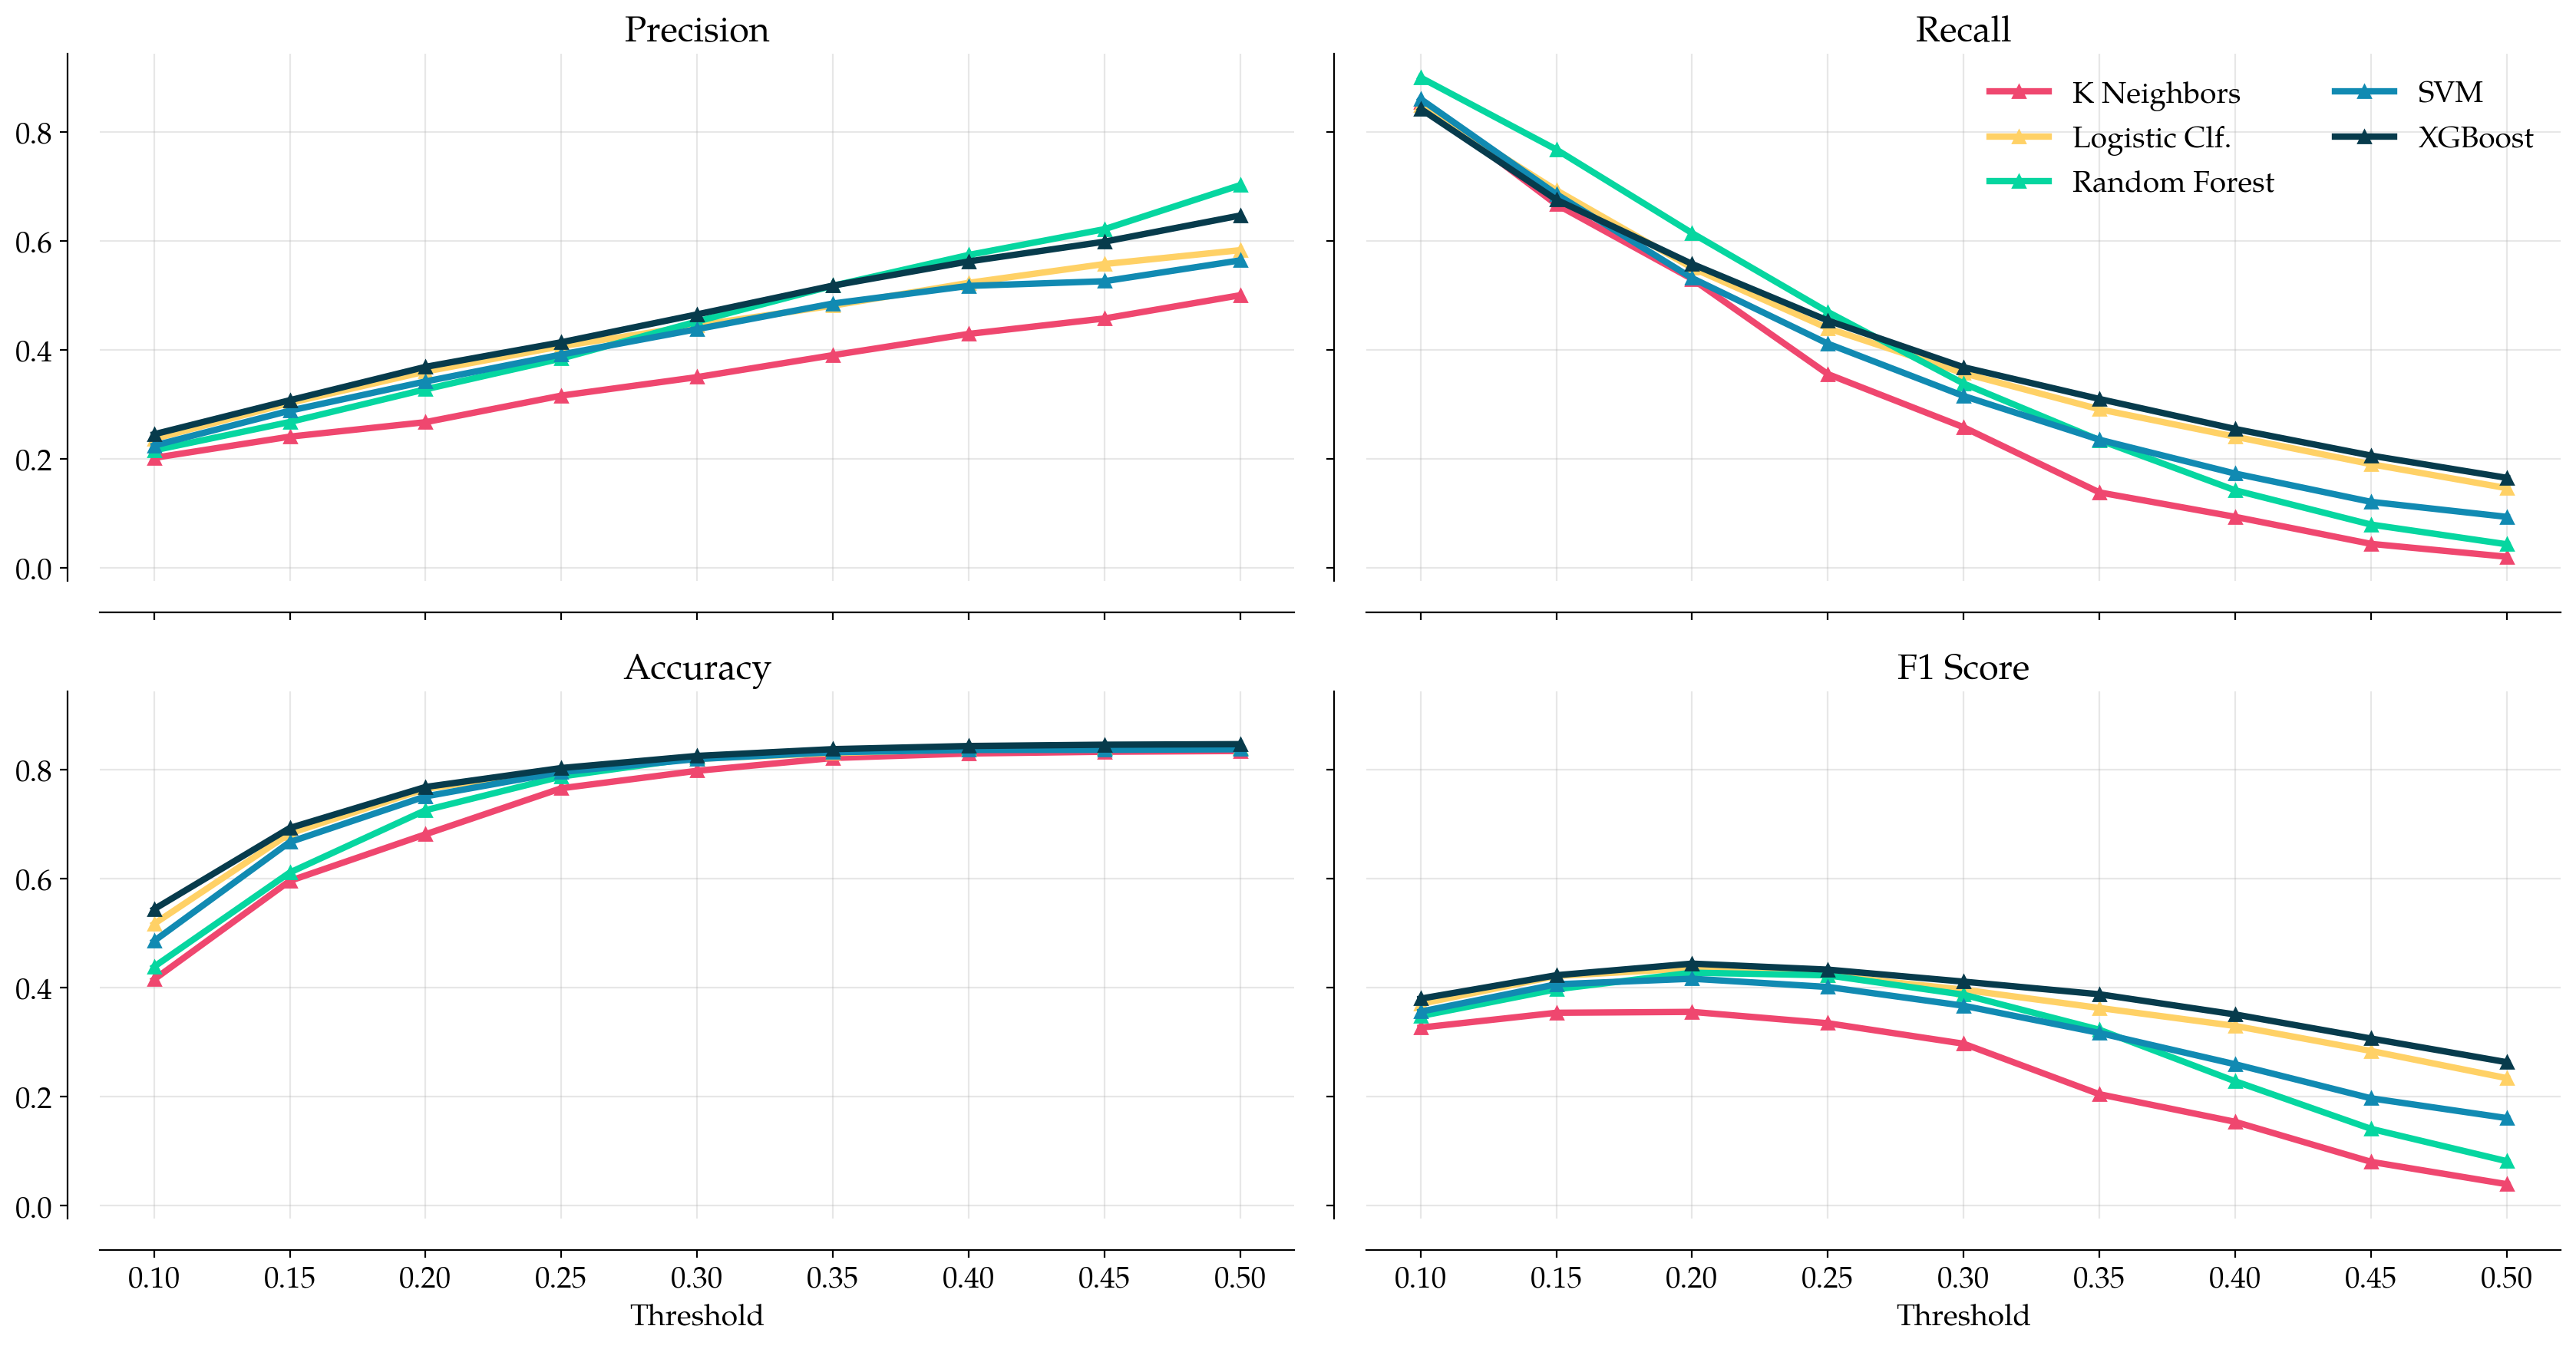

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(17, 9), sharex=True, sharey=True)
color = pal
prec.plot(ax=ax[0][0], title="Precision", legend=False, color=color, marker='^', lw=3)
rec.plot(ax=ax[0][1], title="Recall", color=color, marker='^', lw=3)
ax[0][1].legend(fancybox=False, shadow=False, ncol=2, frameon=False)
acc.plot(ax=ax[1][0], title="Accuracy", legend=False, color=color, marker='^', lw=3)
f1.plot(ax=ax[1][1], title="F1 Score", legend=False, color=color, marker='^', lw=3);
ax[0][0].grid(alpha=0.3)
ax[0][1].grid(alpha=0.3)
ax[1][0].grid(alpha=0.3)
ax[1][1].grid(alpha=0.3)
ax[1][1].set_xlabel("Threshold")
ax[1][0].set_xlabel("Threshold")
sns.despine(offset=15, left=False)
plt.tight_layout();
fig.savefig(r"img/otherMetrics.png".format(metric), dpi=300)

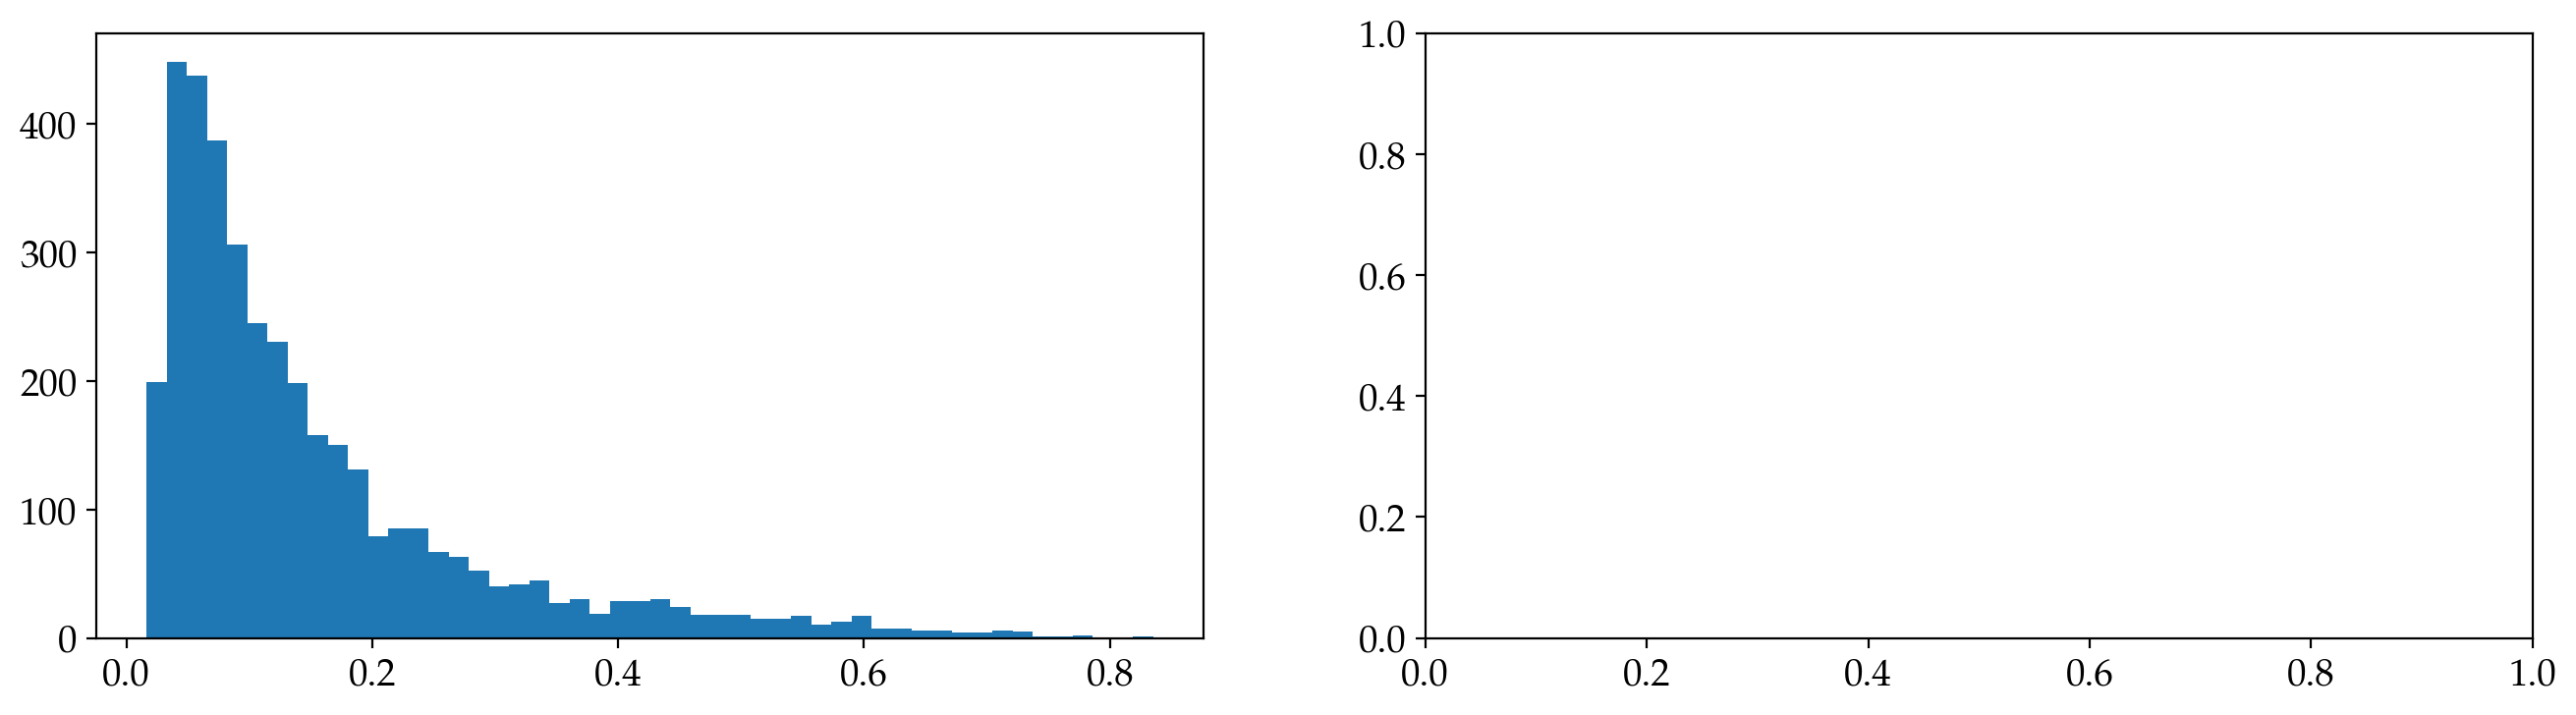

In [24]:
seed = 42
model_name = 'xgboo'
t = 0.1
bins = 50
y_test = parts[seed][-1]
p = models[model_name][seed]['probas']

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sizes, edges, _ = ax[0].hist(p, bins=bins)

def get_types(true, pred):
    tn, fp, fn, tp = 0, 0, 0, 0
    for i in range(len(true)):
        if true[i] == 1 and pred[i] == 1:
            tp += 1
        elif true[i] == 1 and pred[i] == 0:
            fn += 1
        elif true[i] == 0 and pred[i] == 1:
            fp += 1
        elif true[i] == 0 and pred[i] == 0:
            tn += 1
    return tn, fp, fn, tp

results = np.zeros((bins, 4))
for bb in range(bins):
    s = sizes[bb]
    l = edges[bb]
    u = edges[bb + 1]
    idx = np.where((p >= l) & (p <= u))
    px = (p[idx] > t).astype(int)
    r = y_test.values[idx]
    tn, fp, fn, tp = get_types(r, px)
    results[bb, :] = [tn, fp, fn, tp]
results = pd.DataFrame(results, columns=['tn', 'fp', 'fn', 'tp'])

In [25]:
results.columns = ["True Negatives", "False Positives", "False Negatives", "True Positives"]

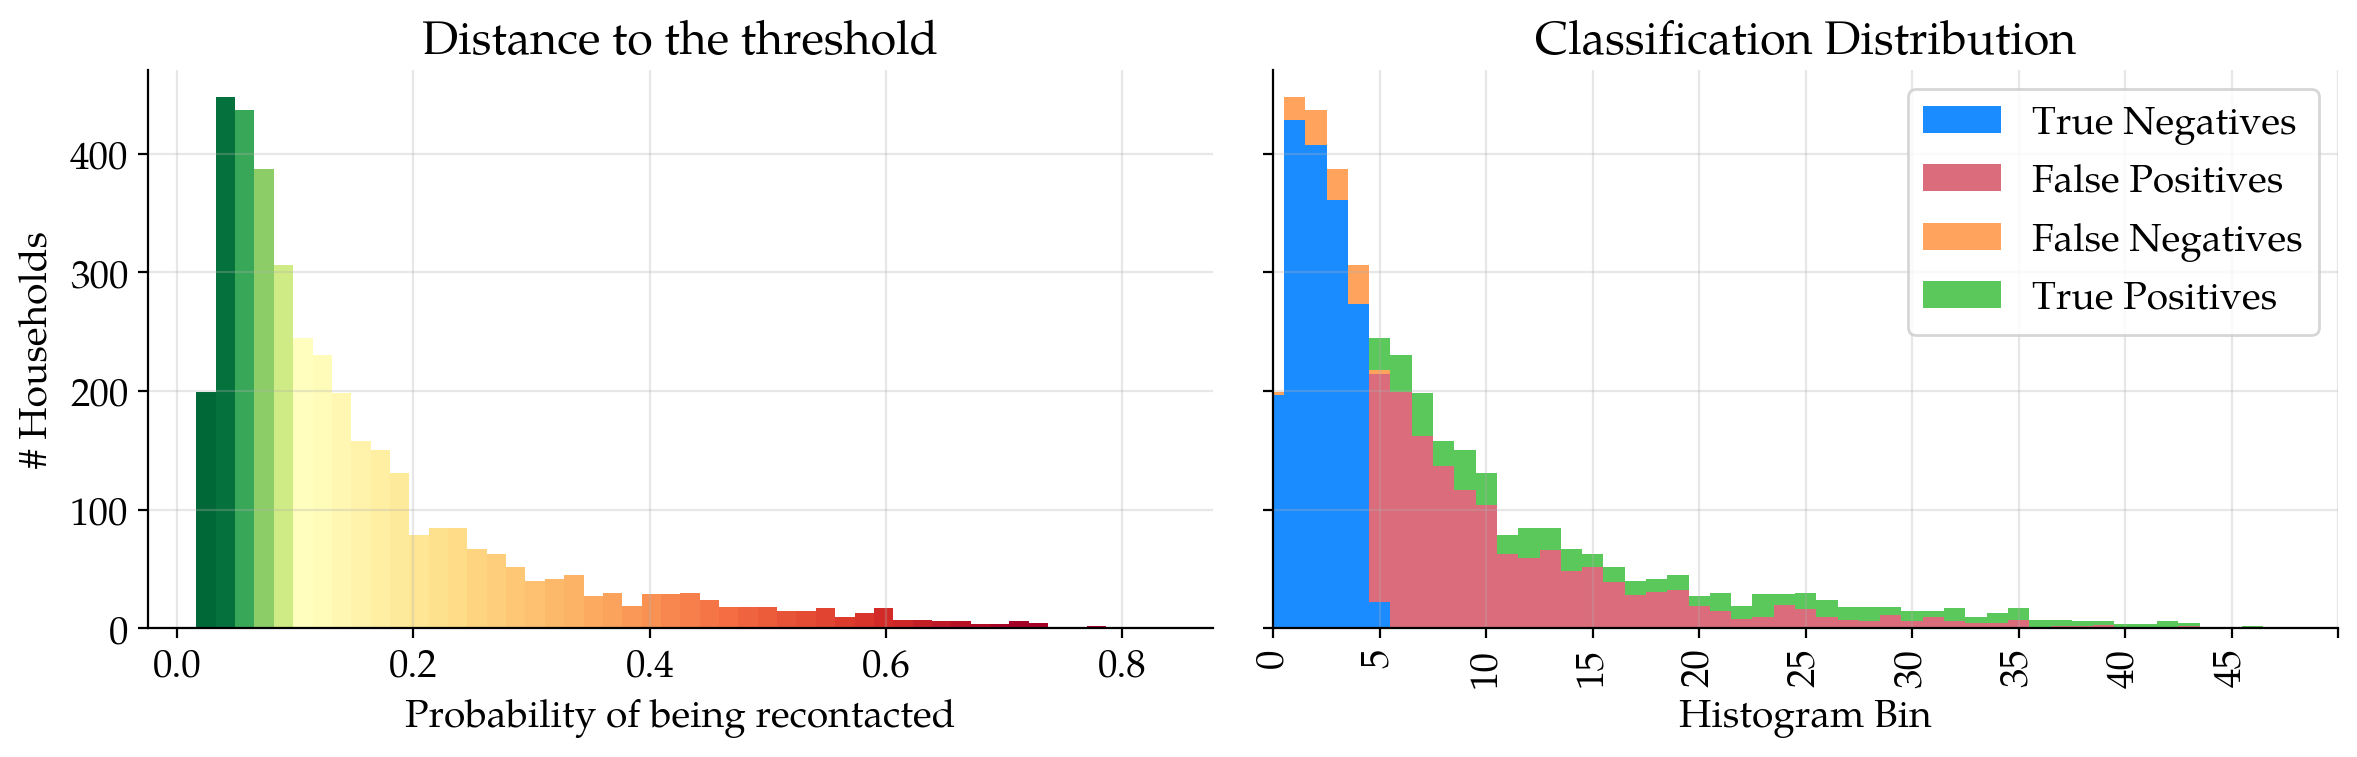

In [26]:
def get_color(th, min_, max_, val):
    if val <= th:
        tot = th - min_
        left = (val - min_) / tot
        return 0.5 * left
    if val >= th:
        tot = max_ - th
        left = (val - th) / tot
        return 0.5 + (0.5 * left)

cm = plt.cm.RdYlGn_r
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sizes, edges, patches = ax[0].hist(p, bins=bins)
ax[0].grid(alpha=0.3)
ax[0].set_title("Distance to the threshold".format(t))
ax[0].set_xlabel("Probability of being recontacted")
ax[0].set_ylabel("# Households")
results.plot.bar(ax=ax[1], stacked=True, width=1,  color=['#1a8cff', '#da6c7b', '#ffa35d', '#5ac85a'],) #  color=['#1a8cff', '#da6c7b', '#ffa35d', '#5ac85a'],
ax[1].set_xticks([0, 5, 10 , 15, 20, 25, 30, 35, 40, 45, 50])
ax[1].set_title("Classification Distribution")
ax[1].set_xlabel("Histogram Bin")
ax[1].set_xlim([0, 50])
# ax[1].set_xticklabels(["0.1", "0.2", "0.3", "0.4"," 0.5", "0.6", "0.7"])
for i, pa in enumerate(patches):
    plt.setp(pa, 'facecolor', cm(get_color(t, p.min(), p.max(), i / len(sizes))))
ax[1].grid(alpha=0.3)
# fig.suptitle("Histograma de probabilidades out-of-sample. Umbral: {}. Modelo: {}".format(t, b[model_name]))
plt.tight_layout()
sns.despine()
fig.savefig(r"img/lights2.png", dpi=300)

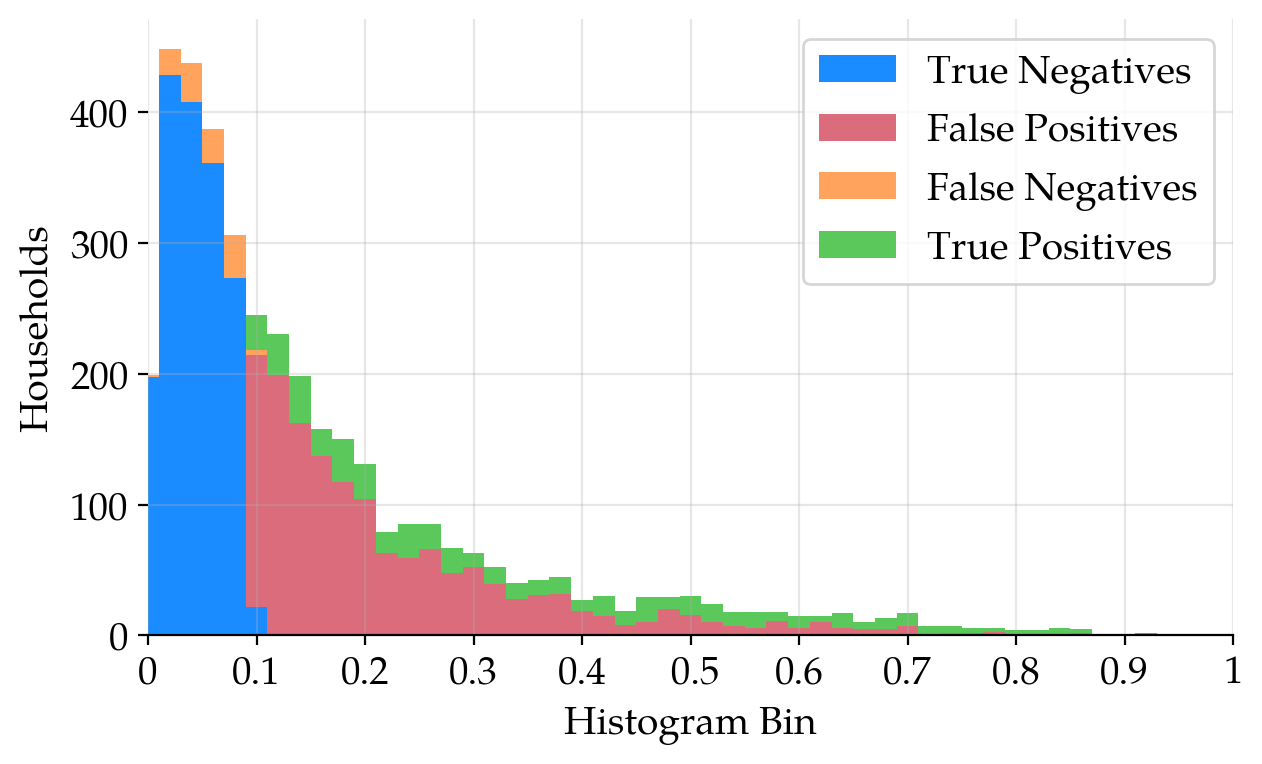

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), sharey=True)
results.plot.bar(ax=ax, stacked=True, width=1,  color=['#1a8cff', '#da6c7b', '#ffa35d', '#5ac85a'],) #  color=['#1a8cff', '#da6c7b', '#ffa35d', '#5ac85a'],
ax.set_xticks([0, 5, 10 , 15, 20, 25, 30, 35, 40, 45, 50])
ax.set_xlabel("Histogram Bin")
ax.set_ylabel("Households")
ax.set_xlim([0, 50])
ax.set_xticklabels(["0", "0.1", "0.2", "0.3", "0.4"," 0.5", "0.6", "0.7", "0.8", "0.9", "1"])
for i, pa in enumerate(patches):
    plt.setp(pa, 'facecolor', cm(get_color(t, p.min(), p.max(), i / len(sizes))))
ax.grid(alpha=0.3)
sns.despine(offset=0, left=True)

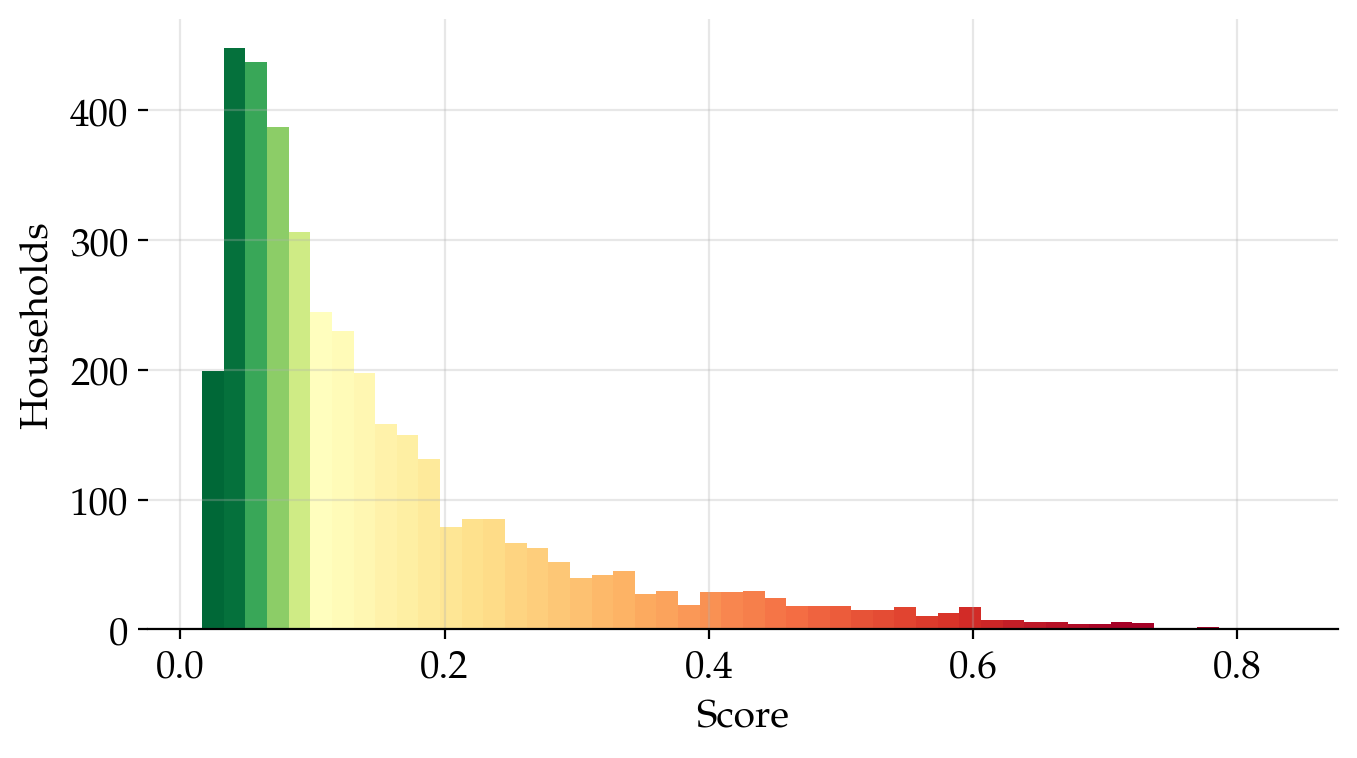

In [28]:
t=.1

def get_color(th, min_, max_, val):
    if val <= th:
        tot = th - min_
        left = (val - min_) / tot
        return 0.5 * left
    if val >= th:
        tot = max_ - th
        left = (val - th) / tot
        return 0.5 + (0.5 * left)

cm = plt.cm.RdYlGn_r
fig, ax = plt.subplots(1, 1, figsize=(7, 4), sharey=True)
sizes, edges, patches = ax.hist(p, bins=bins)
ax.grid(alpha=0.3)
# ax.set_title("Distancia al umbral".format(t))
ax.set_xlabel("Score")
ax.set_ylabel("Households")
# ax[1].set_xticklabels(["0.1", "0.2", "0.3", "0.4"," 0.5", "0.6", "0.7"])
for i, pa in enumerate(patches):
    plt.setp(pa, 'facecolor', cm(get_color(t, p.min(), p.max(), i / len(sizes))))
# fig.suptitle("Histograma de probabilidades out-of-sample. Umbral: {}. Modelo: {}".format(t, b[model_name]))
plt.tight_layout()
sns.despine(offset=0, left=True)
fig.savefig(r"img/lights_t=.15.png", dpi=300)

In [29]:
seed = 42
model_name = 'xgboo'
bins = 50
y_test = parts[seed][-1]
p = models[model_name][seed]['probas']

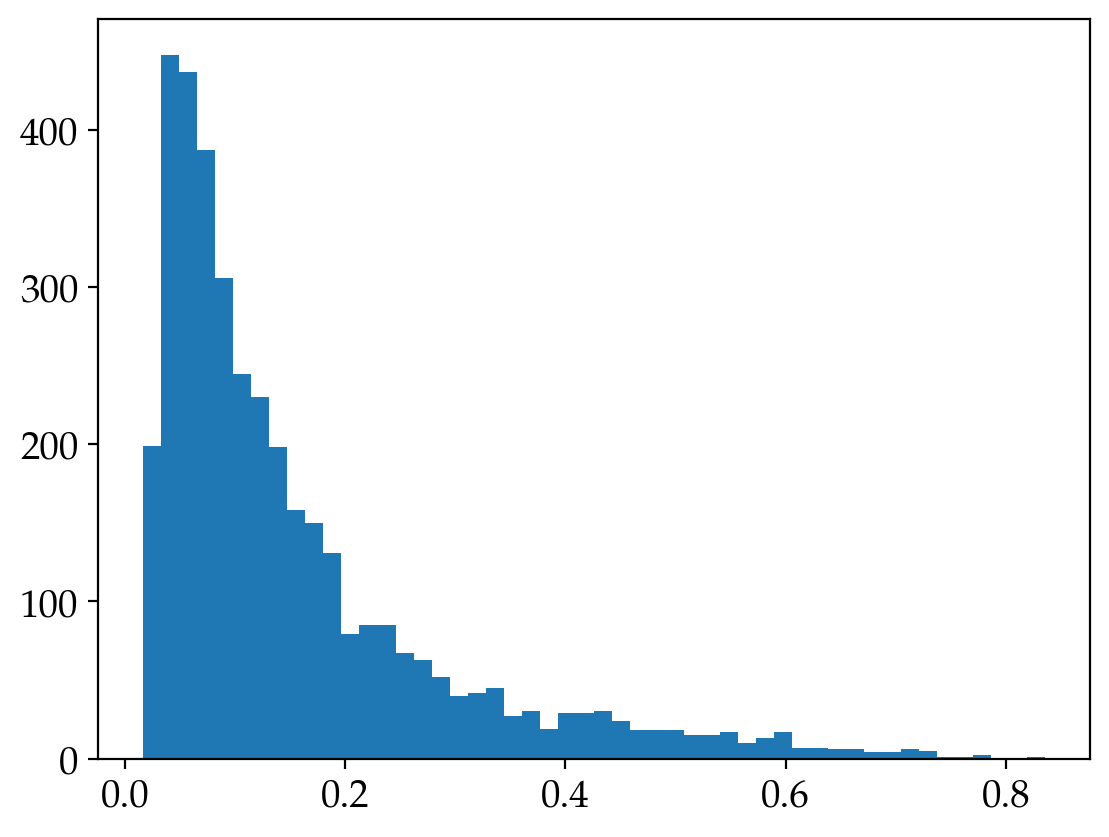

In [30]:
sizes, edges, patches = plt.hist(p, bins=bins)

In [31]:

edges = np.round(edges, 3)

In [32]:
edges[1:]

array([0.033, 0.049, 0.066, 0.082, 0.098, 0.115, 0.131, 0.147, 0.164,
       0.18 , 0.197, 0.213, 0.229, 0.246, 0.262, 0.278, 0.295, 0.311,
       0.328, 0.344, 0.36 , 0.377, 0.393, 0.409, 0.426, 0.442, 0.459,
       0.475, 0.491, 0.508, 0.524, 0.541, 0.557, 0.573, 0.59 , 0.606,
       0.622, 0.639, 0.655, 0.672, 0.688, 0.704, 0.721, 0.737, 0.753,
       0.77 , 0.786, 0.803, 0.819, 0.835])

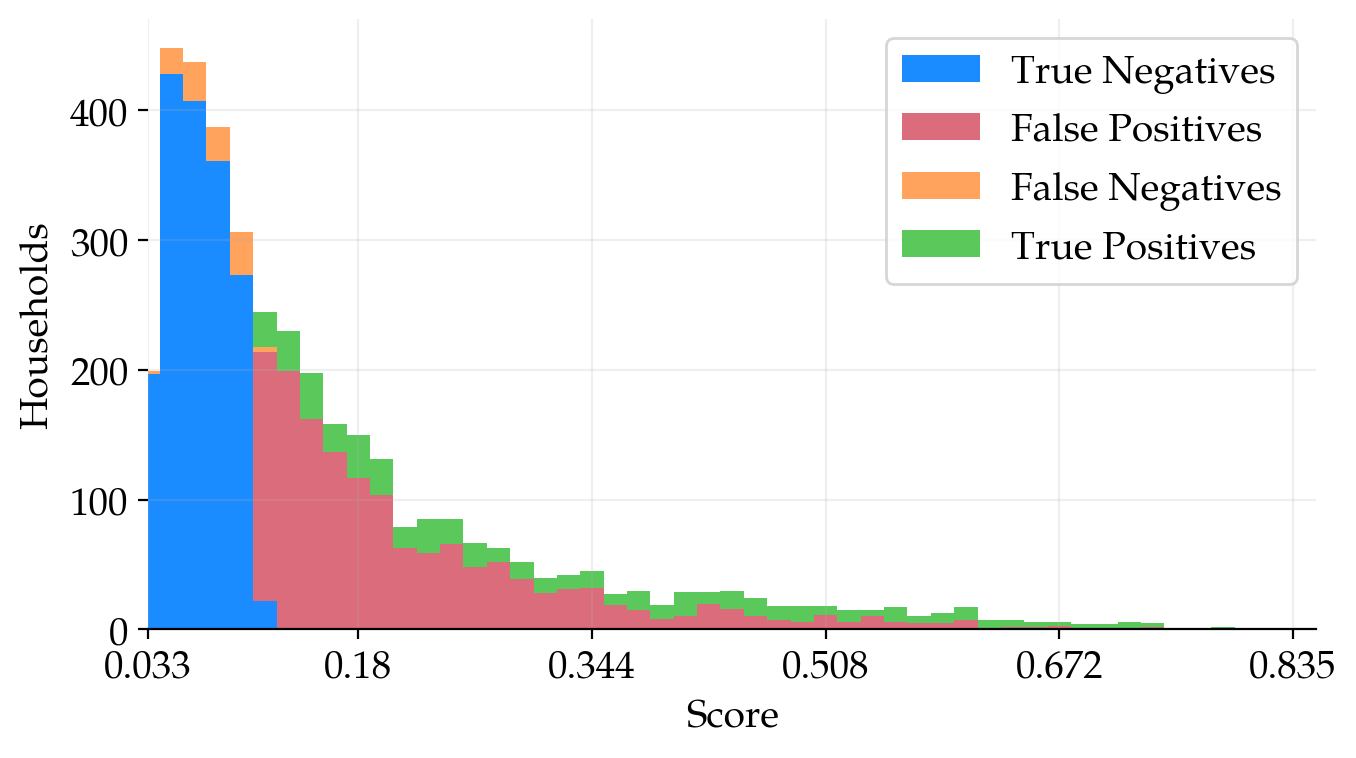

In [33]:
cm = plt.cm.RdYlGn_r
fig, ax = plt.subplots(1, 1, figsize=(7, 4), sharey=True)
results.plot.bar(ax=ax, stacked=True, width=1,  color=['#1a8cff', '#da6c7b', '#ffa35d', '#5ac85a'],) #  color=['#1a8cff', '#da6c7b', '#ffa35d', '#5ac85a'],
ax.set_xticklabels(edges[1:])
# ax.set_title("Classification Distribution")
ax.set_xlabel("Score")
ax.set_ylabel("Households")
ax.set_xlim([0, 50])
# for i, pa in enumerate(patches):
#    plt.setp(pa, 'facecolor', cm(get_color(t, p.min(), p.max(), i / len(sizes))))
ax.set_xticks([0, 9, 19, 29, 39, 49])
plt.xticks(rotation=0)
ax.grid(alpha=0.2)
# fig.suptitle("Histograma de probabilidades out-of-sample. Umbral: {}. Modelo: {}".format(t, b[model_name]))
plt.tight_layout()
sns.despine(left=True)
fig.savefig(r"img/histogram.png", dpi=300)

In [34]:
results.sum(0)

True Negatives     1688.0
False Positives    1502.0
False Negatives     115.0
True Positives      521.0
dtype: float64

# Performance - train

In [35]:
font_dir = r'C:\Users\q31984\AppData\Local\Microsoft\Windows\Fonts\palatino.ttf'
font_manager.fontManager.addfont(font_dir)
plt.rcParams['font.family'] = 'Palatino'
plt.rcParams['font.size'] = 14

In [36]:
models[mod][seed].keys()

dict_keys(['model', 'probas', 'probas_tr'])

In [37]:
res = dict(zip(mods, [None] * len(mods)))

for j, mod in enumerate(mods):
    mm = np.empty((len(seeds), 4))
    for i, seed in enumerate(seeds):
        p = (models[mod][seed]['probas_tr'] > 0.5).astype(int)
        m1 = roc_auc_score(parts[seed][2], models[mod][seed]['probas_tr'])
        m2 = precision_recall_curve(parts[seed][2], models[mod][seed]['probas_tr'])
        m2 = auc(m2[1], m2[0])
        m3 = average_precision_score(parts[seed][2], models[mod][seed]['probas_tr'])
        m4 = matthews_corrcoef(parts[seed][2], p)
        mm[i, :] = [m1, m2, m3, m4]
    res[mod] = pd.DataFrame(mm, columns=['roc', 'prc', 'avp', 'mcc'])

In [38]:
   
m1 = res['logreg'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m1['model'] = 'logreg'
# m2 = res['naivebayes'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
# m2['model'] = 'naivebayes'
m3 = res['svm'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m3['model'] = 'svm'
m4 = res['randfor'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m4['model'] = 'randfor'
m5 = res['xgboo'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m5['model'] = 'xgboo'
m6 = res['kneigh'].stack().reset_index().drop("level_0", axis=1).rename(columns={'level_1': 'metric', 0: "value"})
m6['model'] = 'kneigh'
mm = pd.concat([m5, m1, m4, m3, m6]) # m2

In [39]:
mm = mm.replace({'metric': {"roc": "AUC-ROC Score", "avp": "Average Precision Score", "prc": "Precision-Recall AUC Score",
                           "mcc": "Mathew's Correlation Coefficient"}, 
            'model': {"logreg": "Logistic Clf.", "randfor": "Random Forest", 
                      "xgboo": "XGBoost", 'naivebayes': 'N. Bayes', "svm": 'SVM', "kneigh": "K Neighbors"}}).rename(
columns={'metric': 'Métrica', "value": "Valor", "model": 'Model'})

In [40]:
mm

,Métrica,Valor,Model
0,AUC-ROC Score,0.858869,XGBoost
1,Precision-Recall AUC Score,0.628700,XGBoost
2,Average Precision Score,0.628833,XGBoost
3,Mathew's Correlation Coefficient,0.419030,XGBoost
4,AUC-ROC Score,0.944633,XGBoost
...,...,...,...
35,Mathew's Correlation Coefficient,0.079872,K Neighbors
36,AUC-ROC Score,0.721271,K Neighbors
37,Precision-Recall AUC Score,0.344761,K Neighbors
38,Average Precision Score,0.336245,K Neighbors


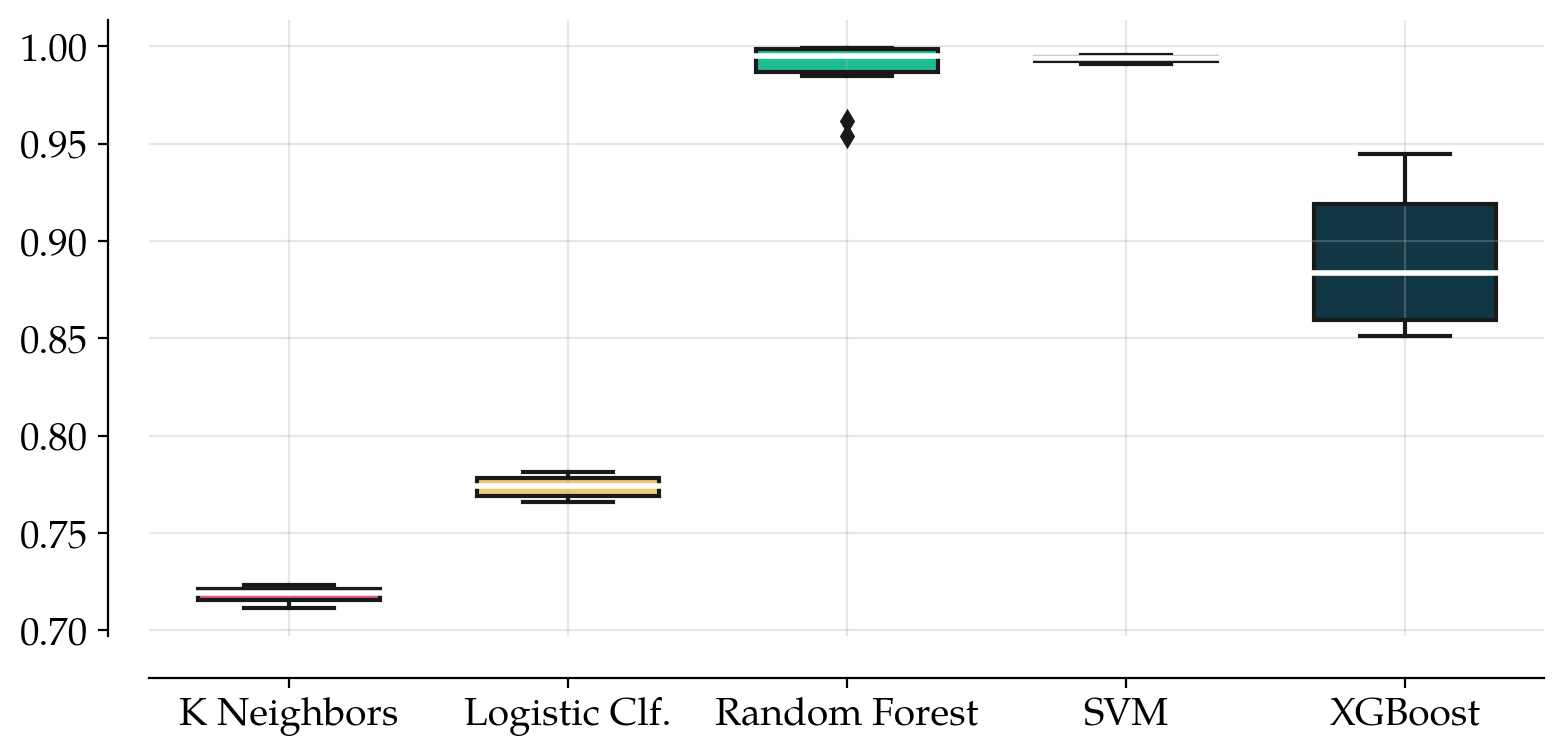

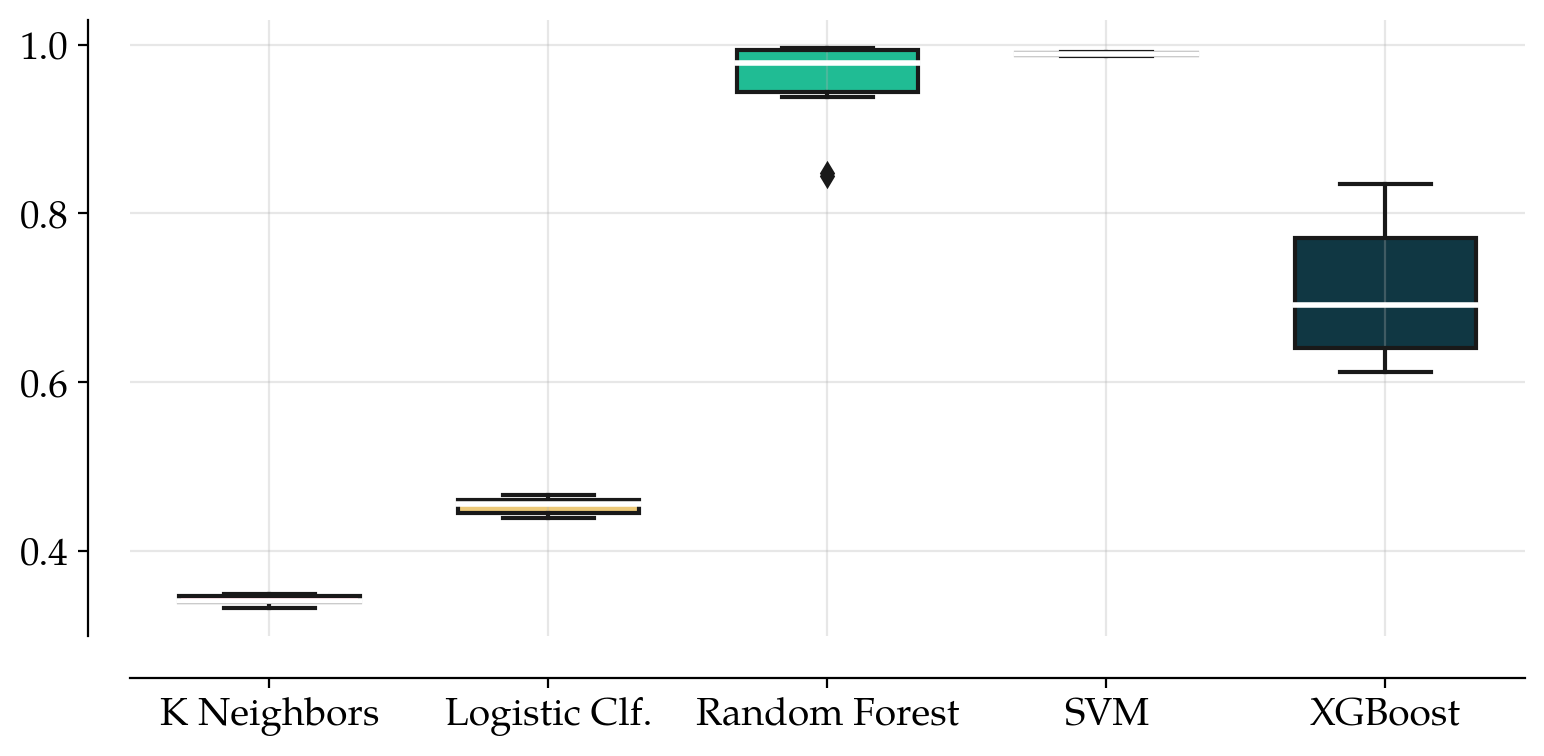

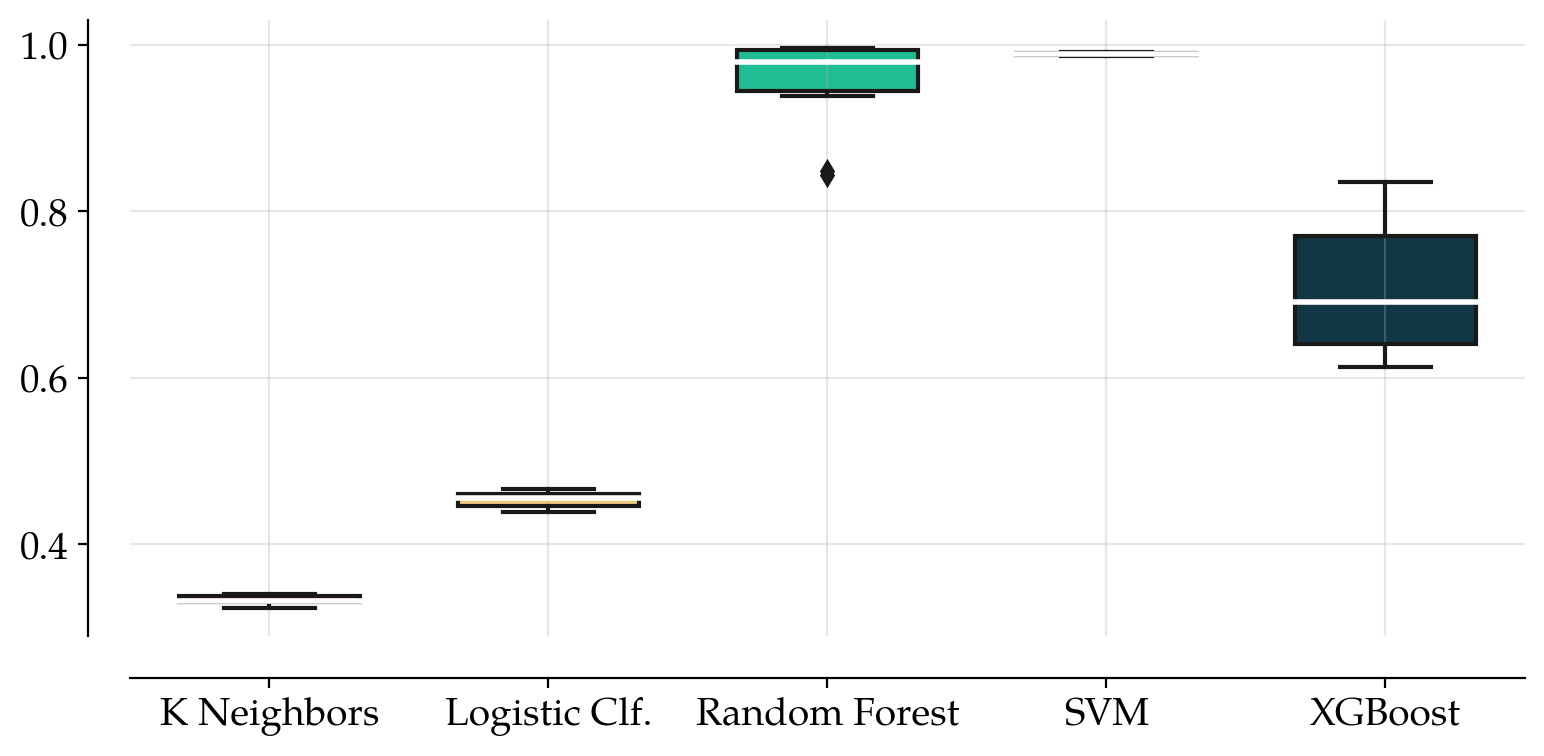

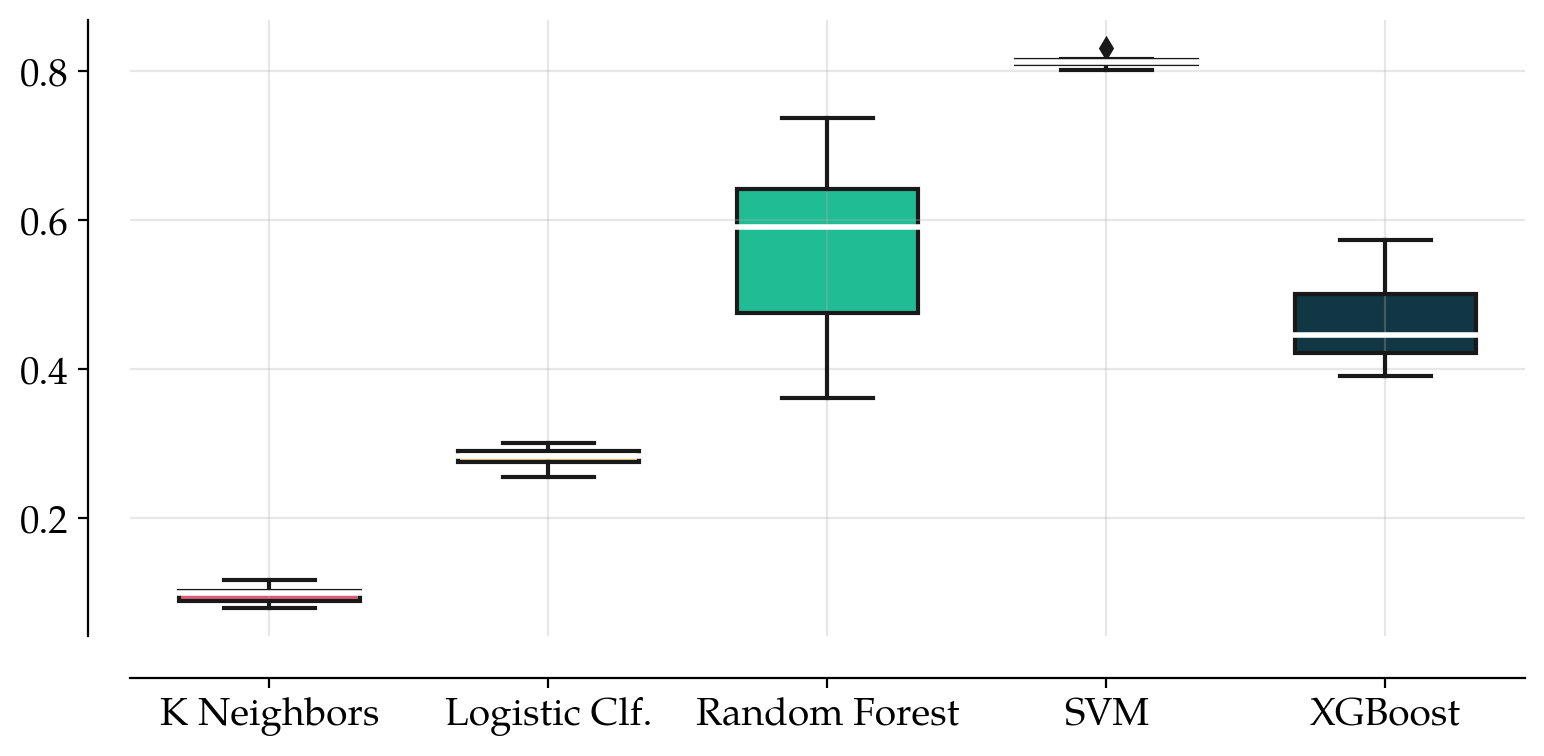

In [41]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from matplotlib import font_manager


pal = ['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c']

for metric in mm['Métrica'].unique():
    
    fig, ax = plt.subplots(1,1, figsize=(9, 4))
    df = mm[mm['Métrica']==metric].sort_values(by='Model')
    #sns.swarmplot(x='Model', y='Valor', data=df, palette=pal, size=10)
    sns.boxplot(x='Model', y='Valor', data=df, palette=pal, 
                linewidth=1.5, width=.65,
                medianprops=dict(color="white", alpha=1, linewidth=2))
    # sns.barplot(x='Model', y='Valor', data=df, ci=None, alpha=0.3)
    ax.grid(alpha=0.3)
    ax.set(xlabel=None, ylabel=None)
    # ax.set_title("Model performance for {}".format(metric))
    sns.despine(offset=15);
    fig.savefig(r"img/{}_train.png".format(metric), dpi=300)
    
    

In [42]:
print(mm.groupby(['Model', 'Métrica']).mean().reset_index().pivot(
    values='Valor', columns='Métrica', index='Model').round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
Métrica &  AUC-ROC Score &  Average Precision Score &  Mathew's Correlation Coefficient &  Precision-Recall AUC Score \\
Model         &                &                          &                                   &                             \\
\midrule
K Neighbors   &          0.718 &                    0.333 &                             0.098 &                       0.342 \\
Logistic Clf. &          0.774 &                    0.453 &                             0.282 &                       0.453 \\
Random Forest &          0.988 &                    0.953 &                             0.559 &                       0.953 \\
SVM           &          0.994 &                    0.989 &                             0.813 &                       0.989 \\
XGBoost       &          0.890 &                    0.707 &                             0.466 &                       0.707 \\
\bottomrule
\end{tabular}



C:\Users\q31984\AppData\Local\Temp\ipykernel_35264\1888333554.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mm.groupby(['Model', 'Métrica']).mean().reset_index().pivot(


In [43]:
print(mm.groupby(['Model', 'Métrica']).std().reset_index().pivot(
    values='Valor', columns='Métrica', index='Model').round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
Métrica &  AUC-ROC Score &  Average Precision Score &  Mathew's Correlation Coefficient &  Precision-Recall AUC Score \\
Model         &                &                          &                                   &                             \\
\midrule
K Neighbors   &          0.004 &                    0.005 &                             0.012 &                       0.005 \\
Logistic Clf. &          0.006 &                    0.009 &                             0.015 &                       0.009 \\
Random Forest &          0.016 &                    0.059 &                             0.125 &                       0.059 \\
SVM           &          0.001 &                    0.002 &                             0.008 &                       0.002 \\
XGBoost       &          0.035 &                    0.081 &                             0.062 &                       0.081 \\
\bottomrule
\end{tabular}



C:\Users\q31984\AppData\Local\Temp\ipykernel_35264\2036604375.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mm.groupby(['Model', 'Métrica']).std().reset_index().pivot(


## Interpretability

In [44]:
import shap

C:\trabajo\anaconda\env\ent03\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
model = 'xgboo'
seed = 10

modelobj = models[model][seed]['model']
probas = models[model][seed]['probas']
X_train, X_test, y_train, y_test = parts[seed]

In [46]:
metric1 = roc_auc_score(y_test, probas)
metric2 = average_precision_score(y_test, probas)
print("XGBoost Test --> AUC: {:.2f}; PR: {:.2f}".format(metric1 * 100, metric2 * 100))

XGBoost Test --> AUC: 76.84; PR: 45.51


In [47]:
explainer = shap.TreeExplainer(modelobj)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


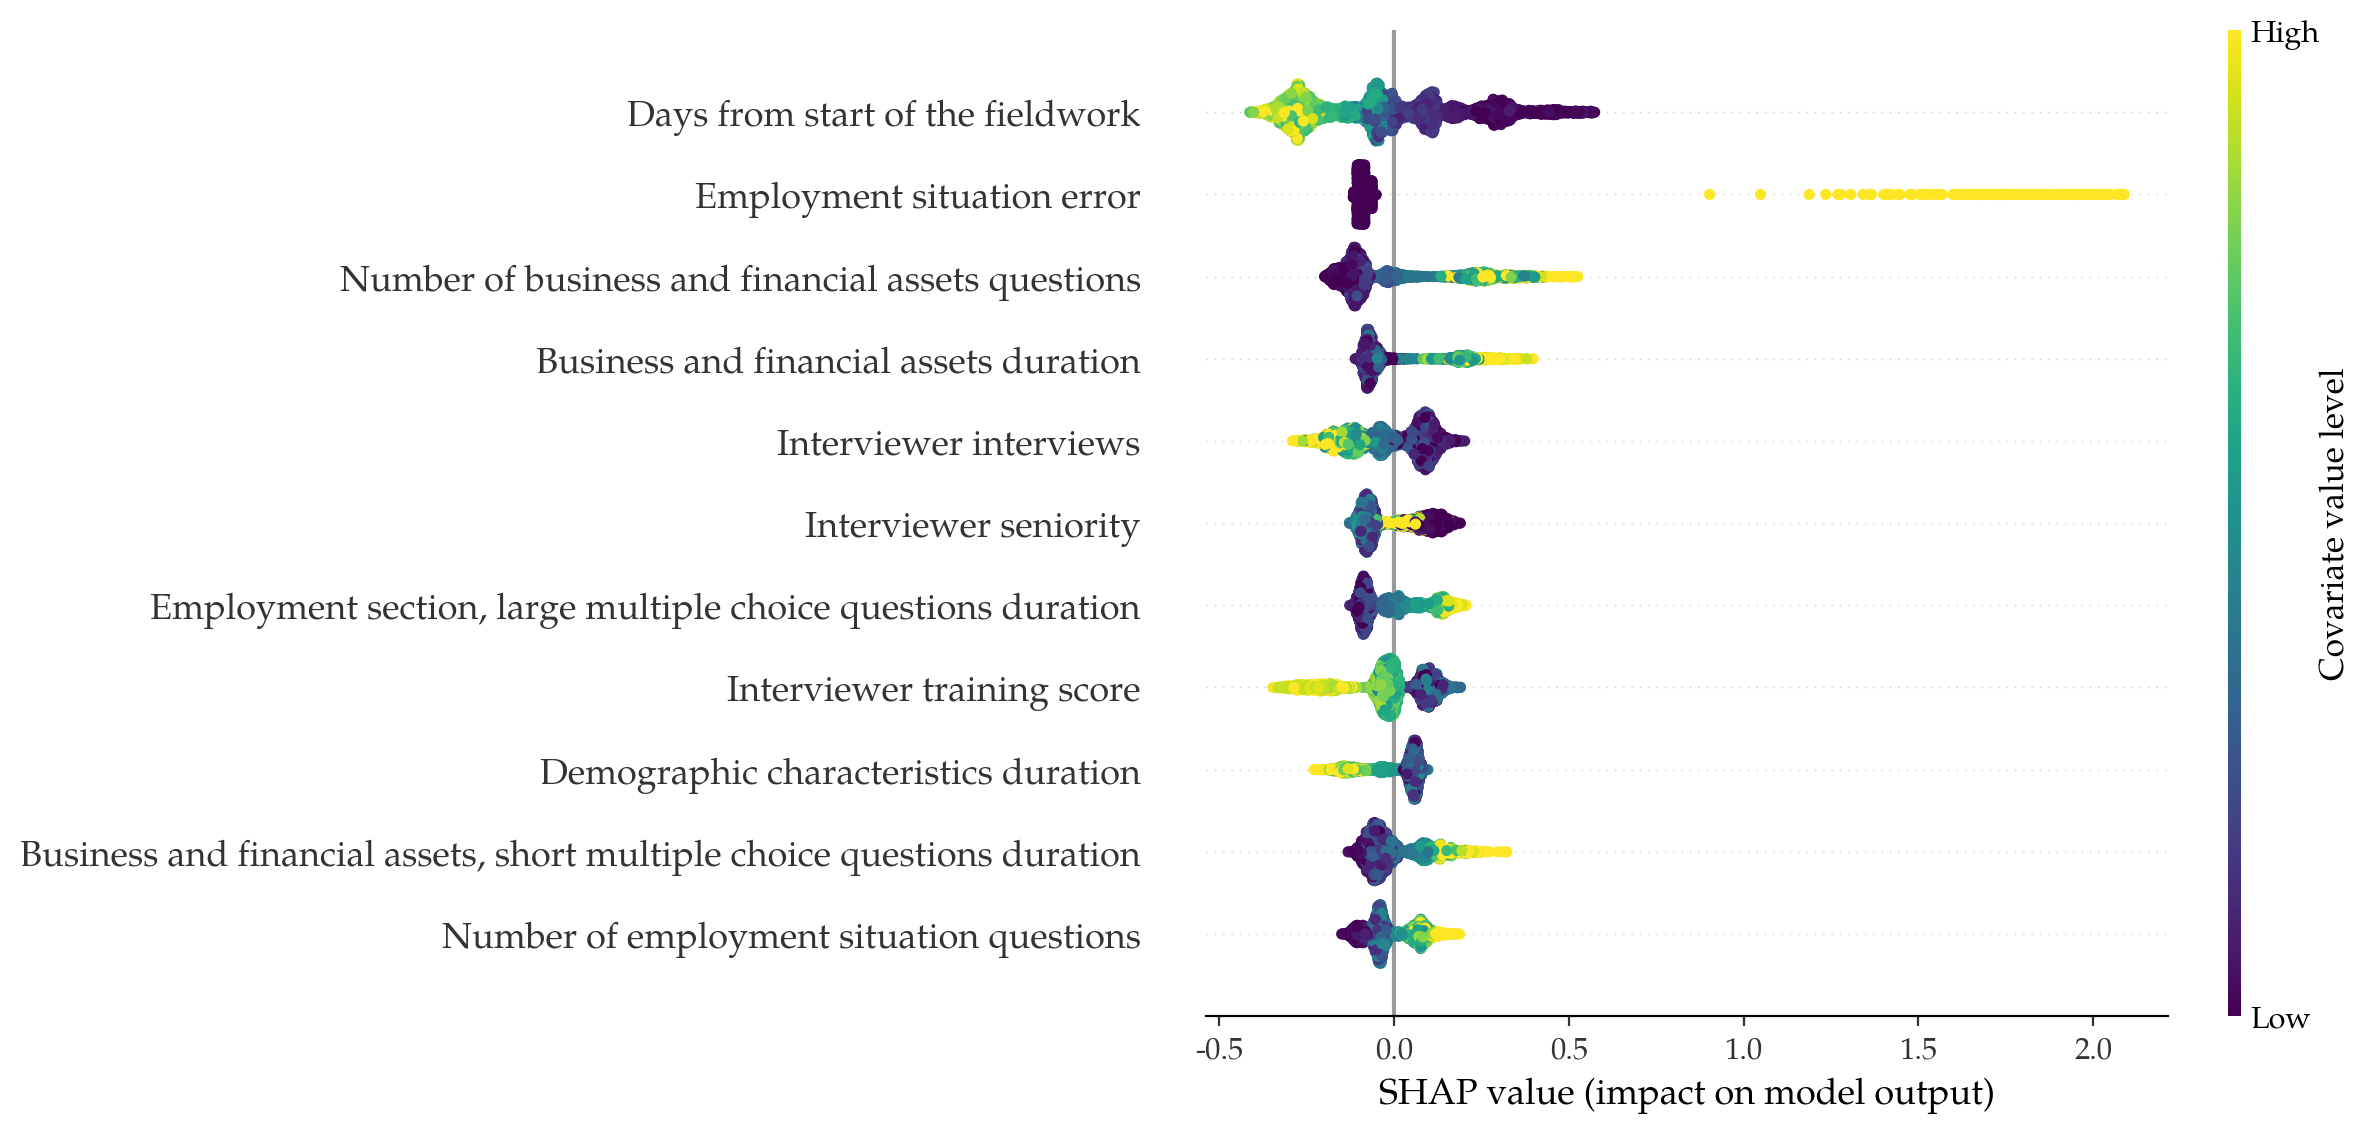

In [48]:
my_cmap = plt.get_cmap('viridis')
feats = ['Days from start of the fieldwork', 
         "Employment situation error",
         'Number of business and financial assets questions', 
         'Business and financial assets duration',         
         'Interviewer interviews',
         'Interviewer seniority',
         "Employment section, large multiple choice questions duration",         
         'Interviewer training score',
         "Demographic characteristics duration",
         'Business and financial assets, short multiple choice questions duration',
          "Number of employment situation questions"]
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
shap.summary_plot(shap_values, X_test, max_display=len(feats), show=False, color_bar_label='Covariate value level')

ax.set_yticklabels(list(reversed(feats)), fontsize=13)
# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
fig.show()
plt.rc('axes', unicode_minus=False)
#fig.colorbar.make_axes(aspect=50)#plt.colorbar(aspect=50)
fig.savefig("img/shapXgboost.png", dpi=300, bbox_inches='tight')

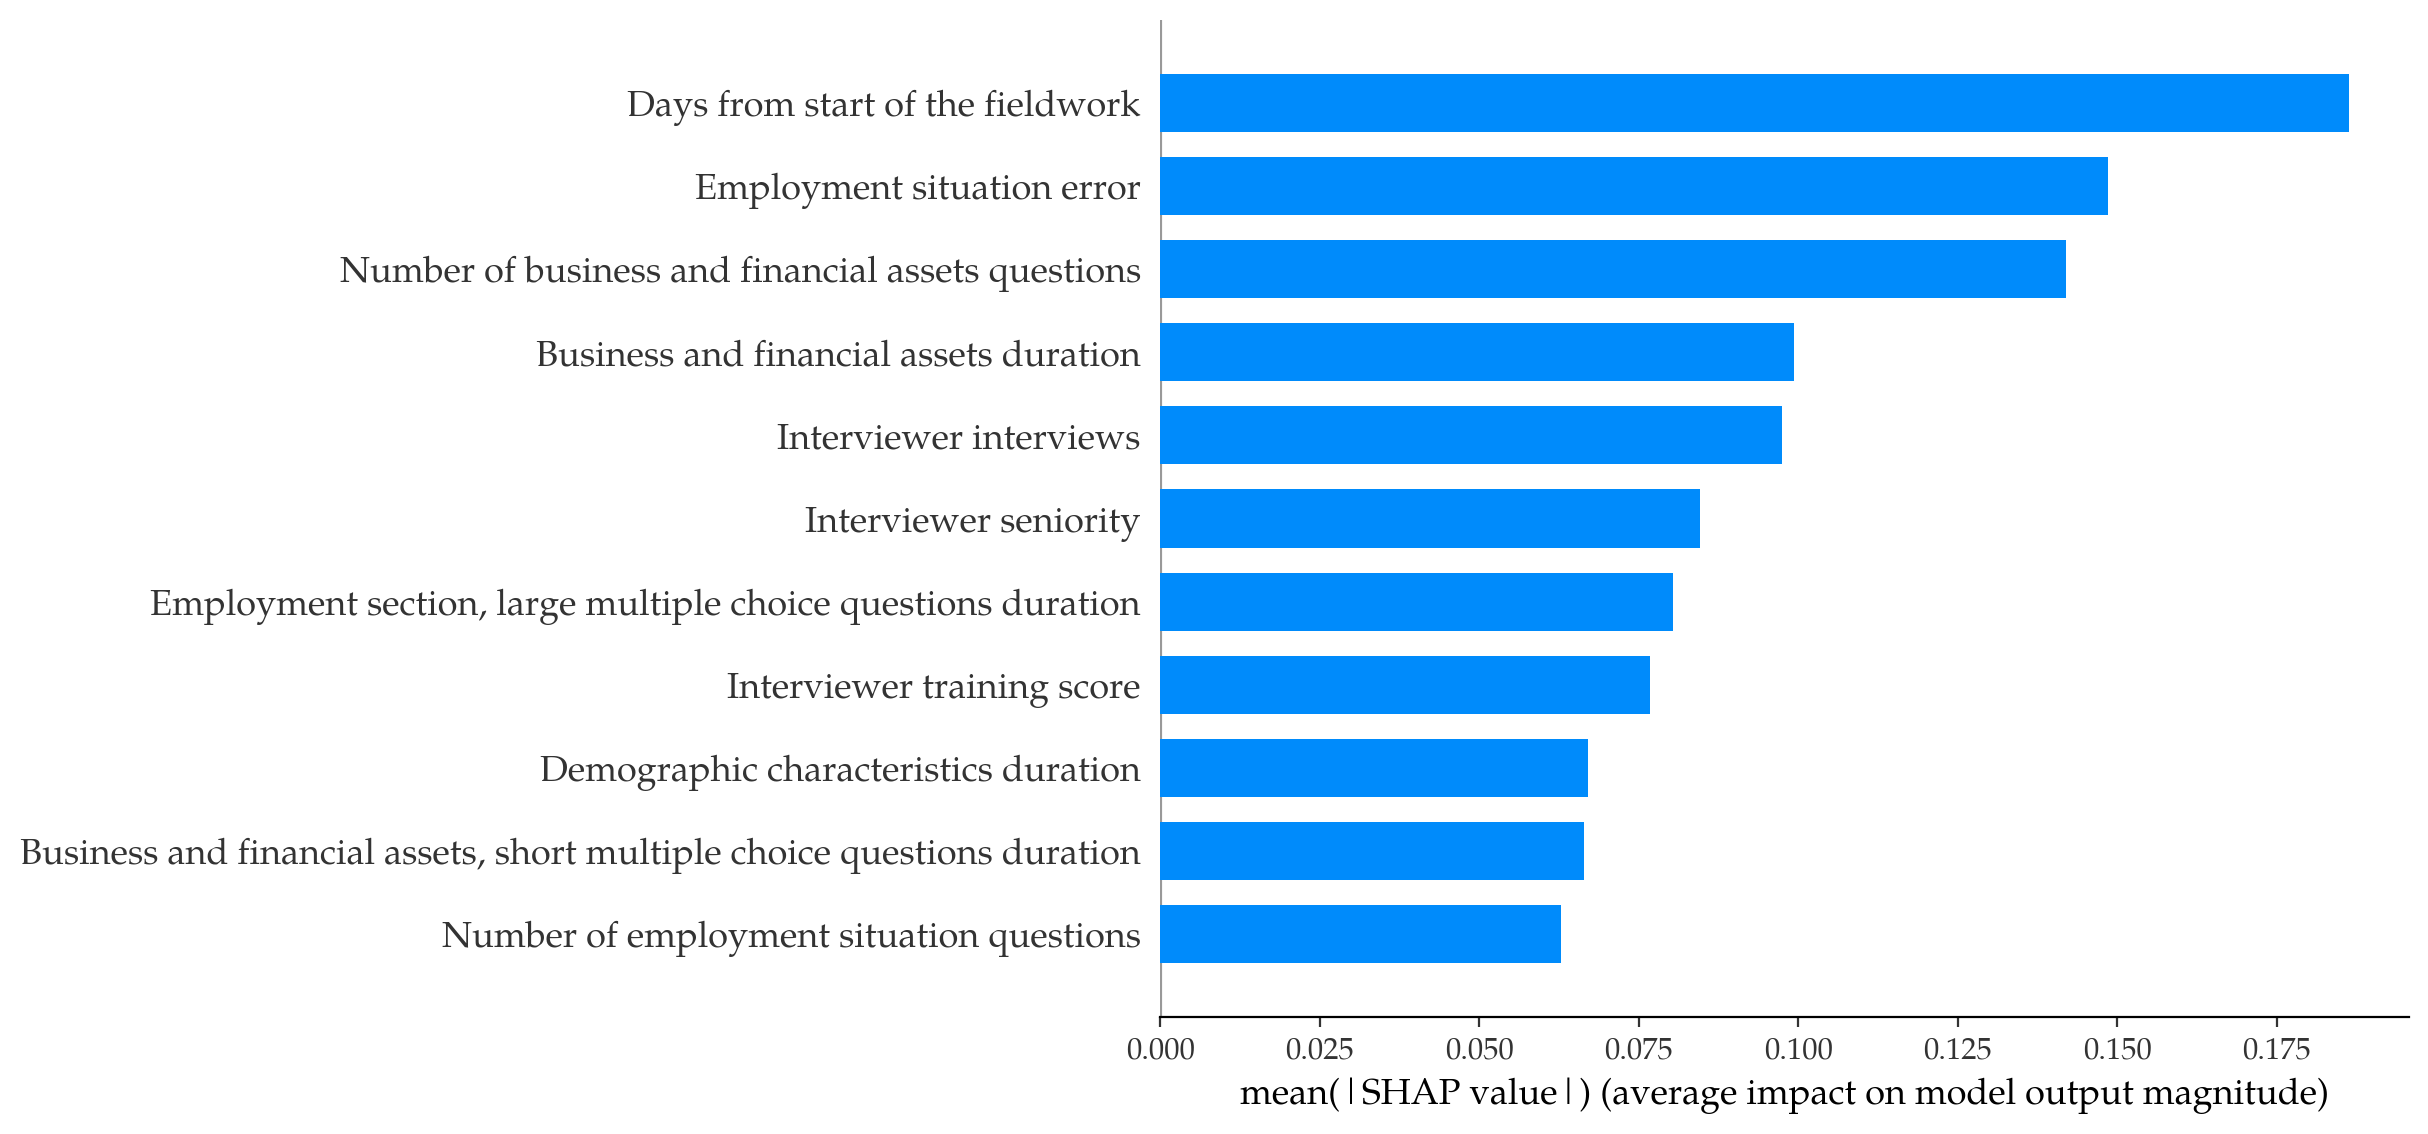

In [49]:
fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values, X_test, plot_type="bar",  max_display=len(feats), show=False)
ax.set_yticklabels(list(reversed(feats)), fontsize=13)
plt.rc('axes', unicode_minus=False)
fig.savefig("img/shapXgboost_means.png", dpi=300, bbox_inches='tight')

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, auc

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
from matplotlib import font_manager

font_dir = r'C:\Users\q31984\AppData\Local\Microsoft\Windows\Fonts\palatino.ttf'
font_manager.fontManager.addfont(font_dir)
plt.rcParams['font.family'] = 'Palatino'
plt.rcParams['font.size'] = 14


def roc_score(true, p):
    if true.sum() > 2:
         return roc_auc_score(true, p)
    else:
        return np.nan

In [ ]:
idname = "cuest_2022"
preds = pd.read_excel(r"Q:\EFF2022\PowerBI\Revision\Recontacto\Datos herramienta detección recontactos.xlsx", index_col=0)


In [ ]:
fecha2 = '2024'

com2 = pd.read_csv(r"datos/oos_data_{}.csv".format(fecha2),index_col=0)
df2 = pd.merge(com2, preds, on=idname)
print("ROC AUC total para {}: {:.2f}".format(fecha2, (roc_auc_score(df2.recontacto, df2.P) * 100).round(3)))

In [ ]:
df2

In [ ]:
df2.fecha = pd.to_datetime(df2.fecha)
dates = pd.bdate_range(df2.fecha.min(), df2.fecha.max())
scores2 = list()
for i, date in enumerate(dates[1:]):
    aux = df2[df2.fecha <= date]
    score = roc_score(aux.recontacto, aux.P)
    scores2.append(score)
scores2 = pd.DataFrame(data=scores2, index=dates[1:], columns=["Score"])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
rate = (df2.groupby("fecha")['recontacto'].sum().cumsum() / df2.groupby("fecha").size().cumsum())
rate.index = pd.to_datetime(rate.index)
rate.asfreq("b").ffill().plot(ax=ax, lw=2, c='blue')
sns.despine(offset=15)
plt.ylim(0, 0.3)
plt.grid(alpha=.3)
# plt.xticks(rotation=45);
plt.xlabel("")

fig.savefig("img/cumrate.png", dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax= scores2.rename(columns={'Score': "Fichero 2023-21-03"}).plot(ax=ax, lw=2, c='blue', legend=False)
sns.despine(offset=15)
plt.grid(alpha=.3);
plt.ylim(0.5, .9)
# plt.xlabel("Interview Date")
fig.savefig("img/cumroc.png", dpi=300, bbox_inches='tight')

In [ ]:
df2size = df2.drop_duplicates().pivot(index='fecha', columns='su_id', values="su_id")
df2size.index= pd.to_datetime(df2size.index)
df2size = (df2size > 0).sum(1).asfreq("B").cumsum().ffill()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
df2size.plot(ax=ax, lw=2, c='blue')
sns.despine(offset=15);
plt.grid(alpha=.3)
plt.ylim(0, 6500)
plt.xlabel("")
fig.savefig("img/cumcases.png", dpi=300, bbox_inches='tight')

In [ ]:
df2.fecha_revision = pd.to_datetime(pd.to_datetime(df2.fecha_revision).dt.date)

# Heatmap

In [52]:
def fbeta_score(recall, precision, weight=1):
    return (weight + 1) / ((weight/recall) + (1 / precision))

In [53]:
from sklearn.metrics import recall_score, precision_score, fbeta_score
ts = np.arange(0.1, 0.51, 0.01)
betas = np.linspace(0.125, 5, 100)

modsfbeta = {name: None for name in mods}
modsprec = {name: None for name in mods}
modsrec = {name: None for name in mods}
modshares= {name: None for name in mods}

for model in mods:
    ms = models[model]
    fbetas_model = None
    rec_model = np.zeros((len(ts), len(seeds)))
    prec_model = np.zeros((len(ts), len(seeds)))
    shares_model = np.zeros((len(ts), len(seeds)))
    for i, seed in enumerate(seeds):
        x_train = parts[seed][0]
        y_train = parts[seed][2]
        x_test = parts[seed][1]
        y_test = parts[seed][-1]
        m = ms[seed]['model']
        p = ms[seed]['probas']
        fbetas_model_seed = list()
        recs = list()
        precs = list()
        shares = list()
        for j, t in enumerate(ts):
            y_pred = (p >= t).astype(int)
            
            share = y_pred.sum() / y_pred.shape[0]
            shares.append(share)
            
            recall = recall_score(y_test, y_pred)
            recs.append(recall)
            
            prec = precision_score(y_test, y_pred)
            precs.append(prec)
            
            fbetas = [fbeta_score(y_test, y_pred, beta=beta) for beta in betas]
            fbetas_model_seed.append(fbetas)
        
        fbetas_model_seed = np.array(fbetas_model_seed)
        if fbetas_model is None:
            fbetas_model = fbetas_model_seed
        else:
            fbetas_model += fbetas_model_seed
        
        rec_model[:, i] = np.array(recs).reshape(-1,)
        prec_model[:, i] = np.array(precs).reshape(-1,)
        shares_model[:, i] = np.array(shares).reshape(-1,)
        
    fbetas_model = fbetas_model / len(seeds)
    
    modsfbeta[model] = fbetas_model
    modsprec[model] = prec_model.mean(1)
    modsrec[model] = rec_model.mean(1)
    modshares[model] = shares_model.mean(1)

In [54]:
a = pd.DataFrame(modsfbeta["xgboo"], index=ts.round(2), columns=betas.round(2))

In [55]:
maxes = a.idxmax(axis=0)

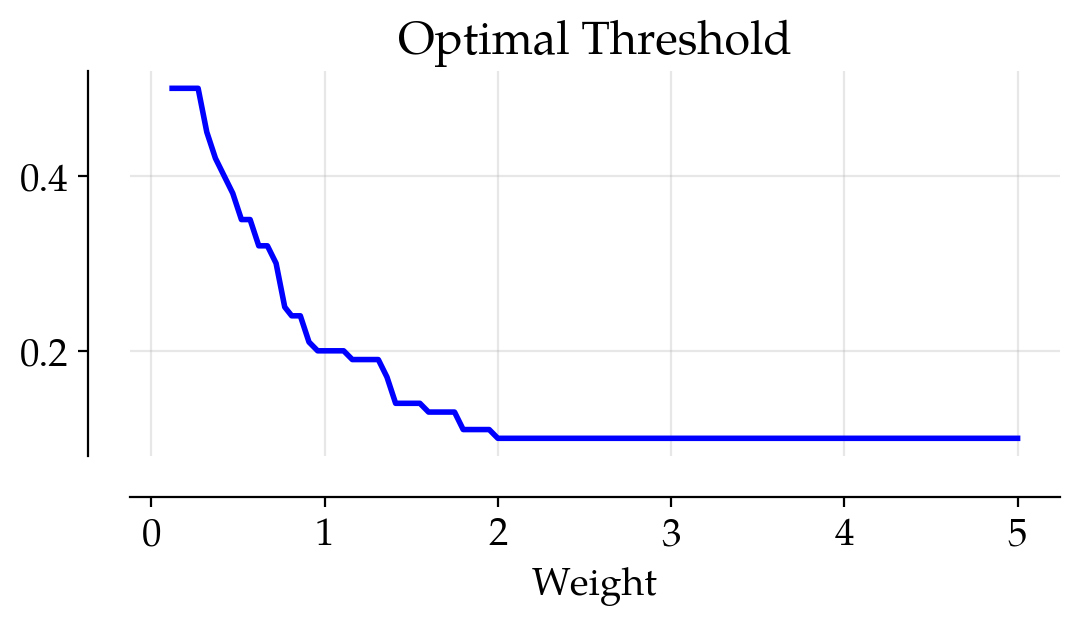

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
maxes.plot(ax=ax, lw=2, c='blue')
sns.despine(offset=15);
plt.grid(alpha=.3)
plt.xlabel("Weight")
plt.title("Optimal Threshold");
fig.savefig(r"img/optim_t.png", dpi=300)

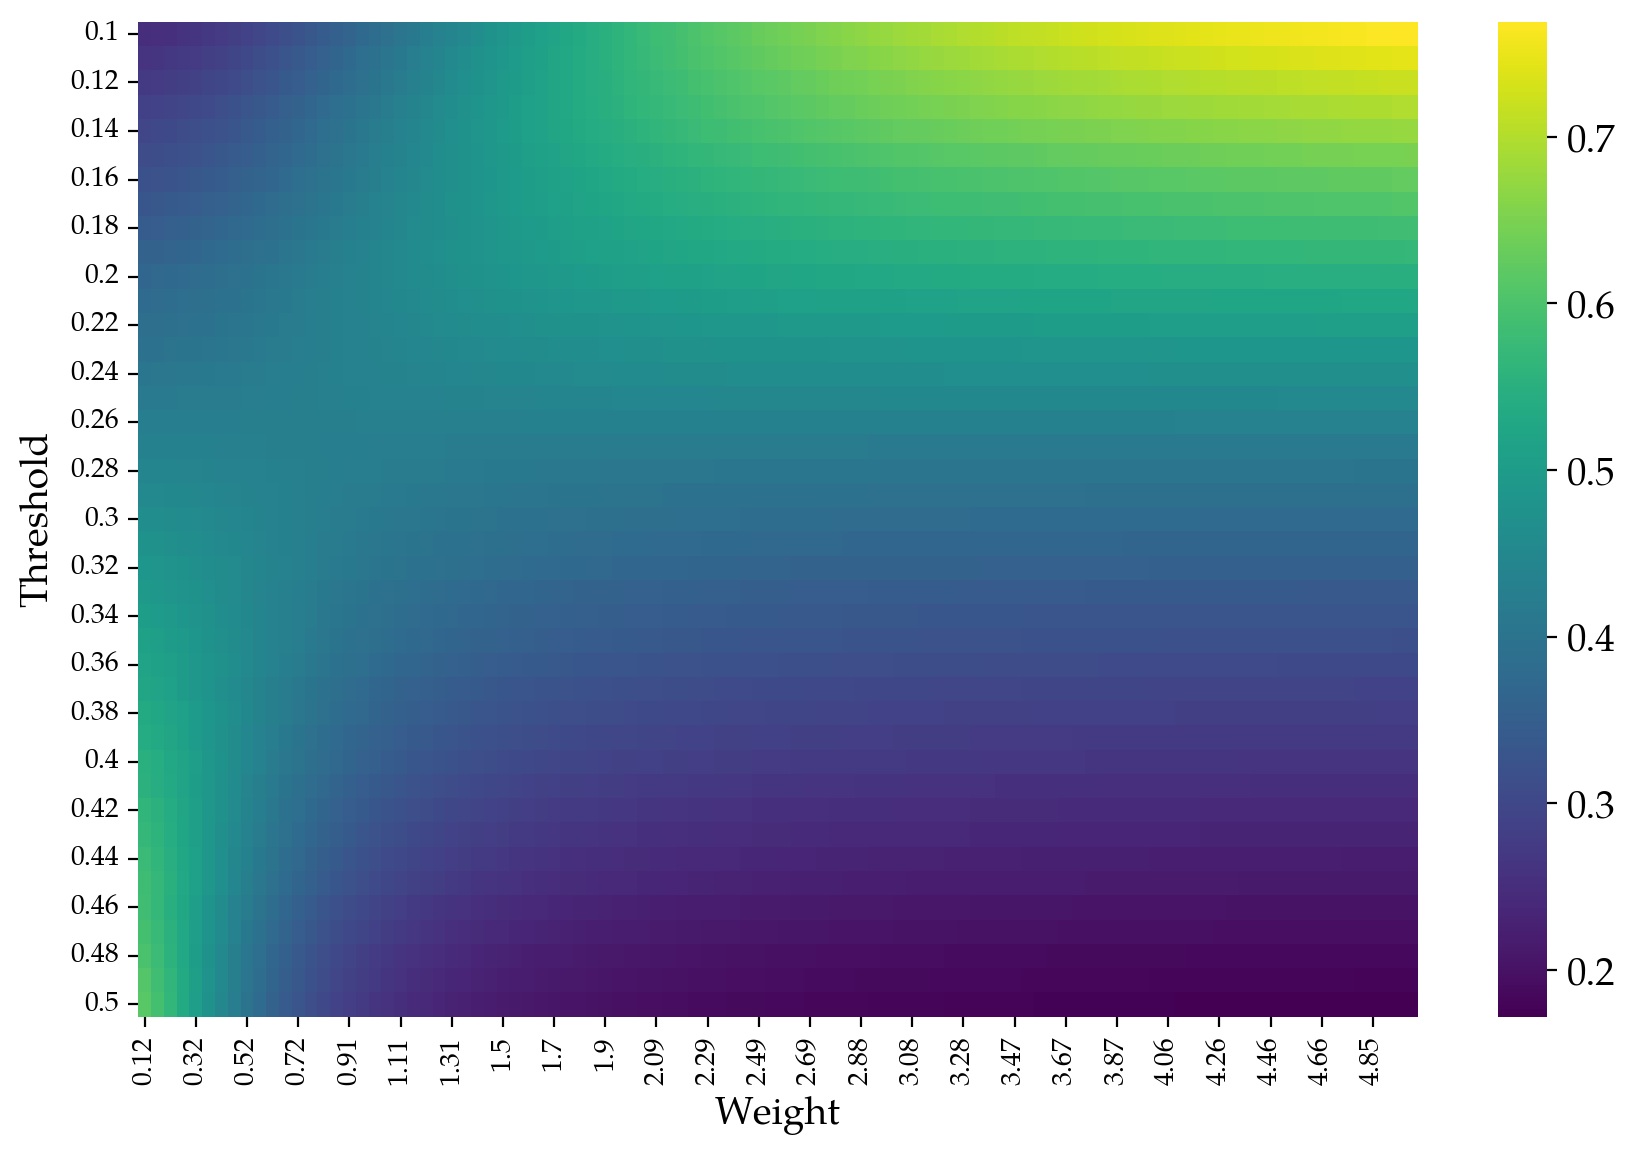

In [57]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(a, cmap='viridis', ax=ax);
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel("Weight")
ax.set_ylabel("Threshold");
plt.tight_layout();
plt.savefig(r"img/xgboost_heatmap_100.jpg", dpi=300)

In [76]:
idmax = a.loc[:, [0.52, 1.01, 1.5, 2.0]].idxmax(0)
tss = idmax.values.tolist()

In [77]:
a1 = pd.DataFrame(modsrec["xgboo"], index=ts.round(2), columns=["Recall"])
a2 = pd.DataFrame(modsprec["xgboo"], index=ts.round(2), columns=["Precision"])
a3 = pd.DataFrame(modshares["xgboo"], index=ts.round(2), columns=["Edited Cases"])

In [78]:
idmax = idmax.reset_index()
idmax.columns = ['Beta', 'Optimal Threshold']

In [79]:
aux = pd.concat([a1.loc[tss], a2.loc[tss], a3.loc[tss], a.loc[tss].max(1).rename("F-Beta Score")], axis=1).reset_index().rename(columns={"index": 'Optimal Threshold'})

In [80]:
aux = pd.merge(idmax, aux, on='Optimal Threshold')

In [81]:
print(aux[["Beta", "Precision", "Recall", "F-Beta Score", "Optimal Threshold", "Edited Cases"]].round(3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Beta &  Precision &  Recall &  F-Beta Score &  Optimal Threshold &  Edited Cases \\
\midrule
0 &  0.52 &      0.515 &   0.312 &         0.510 &               0.35 &         0.101 \\
1 &  1.01 &      0.368 &   0.559 &         0.548 &               0.20 &         0.253 \\
2 &  1.50 &      0.295 &   0.711 &         0.675 &               0.14 &         0.401 \\
3 &  2.00 &      0.246 &   0.841 &         0.769 &               0.10 &         0.568 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
